In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='openpyxl')
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from scipy.stats import ttest_ind, levene, shapiro
import calendar
import numpy as np

In [ ]:
# Función para cargar y procesar una hoja (Ejecutar solo una vez)
'''def cargar_hoja(archivo, hoja, skiprows, moneda):
    df = pd.read_excel(archivo, sheet_name=hoja, skiprows=skiprows, usecols=lambda x: 'Unnamed' not in x)
    df["Moneda"] = moneda
    return df.fillna(method='ffill')

# Cargar todas las hojas
df_eeff_mn = cargar_hoja("Boletín Bancos MN.xlsm", "1. EEFF", 23, "MN")
df_eeff_me = cargar_hoja("Boletín Bancos ME.xlsm", "1. EEFF", 23, "ME")

df_cartera_mn = cargar_hoja("Boletín Bancos MN.xlsm", "3. Cartera", 23, "MN")
df_cartera_me = cargar_hoja("Boletín Bancos ME.xlsm", "3. Cartera", 23, "ME")

df_sector_mn = cargar_hoja("Boletín Bancos MN.xlsm", "5. Cred. por sector", 21, "MN")
df_sector_me = cargar_hoja("Boletín Bancos ME.xlsm", "5. Cred. por sector", 21, "ME")

df_actividad_mn = cargar_hoja("Boletín Bancos MN.xlsm", "6. Cred. por acti", 17, "MN")
df_actividad_me = cargar_hoja("Boletín Bancos ME.xlsm", "6. Cred. por acti", 17, "ME")

# Unir MN y ME por tipo
df_eeff = pd.concat([df_eeff_mn, df_eeff_me], ignore_index=True)
df_cartera = pd.concat([df_cartera_mn, df_cartera_me], ignore_index=True)
df_sector = pd.concat([df_sector_mn, df_sector_me], ignore_index=True)
df_actividad = pd.concat([df_actividad_mn, df_actividad_me], ignore_index=True)

# Guardar en un nuevo archivo Excel con varias hojas
with pd.ExcelWriter("Boletin_Procesado.xlsx", engine='openpyxl') as writer:
    df_eeff.to_excel(writer, sheet_name="EEFF", index=False)
    df_cartera.to_excel(writer, sheet_name="Cartera", index=False)
    df_sector.to_excel(writer, sheet_name="Cred_por_sector", index=False)
    df_actividad.to_excel(writer, sheet_name="Cred_por_actividad", index=False)
    '''

In [2]:
# Cargar todas las hojas del archivo
excel_file = "Boletin_Procesado.xlsx"
sheets_dict = pd.read_excel(excel_file, sheet_name=None)  # Lee todas las hojas como un diccionario

# Guardar cada hoja en un DataFrame separado
df_eeff = sheets_dict["EEFF"]
df_cartera = sheets_dict["Cartera"]
df_sector = sheets_dict["Cred_por_sector"]
df_actividad = sheets_dict["Cred_por_actividad"]

# Mostrar para confirmar
print("Hojas cargadas:")
for nombre in sheets_dict:
    print(f"- {nombre}")

Hojas cargadas:
- EEFF
- Cartera
- Cred_por_sector
- Cred_por_actividad


In [3]:
# Filtrar por sector AGRICULTURA
df_agricultura = df_sector[df_sector['Sector E.'] == 'AGRICULTURA'].copy()

# Convertir columna Fecha a datetime (agregando día)
df_agricultura['Fecha'] = pd.to_datetime(df_agricultura['Fecha'].astype(str) + '/01', format='%Y/%m/%d')

#Borramos la columna 'Sector E.' para evitar duplicados
df_agricultura.drop(columns=['Sector E.'], inplace=True)

In [4]:
# Transponer el DataFrame
df_nuevo = df_agricultura.melt(
    id_vars=["Fecha", "Moneda"],
    var_name="Banco",
    value_name="Credito"
)

In [5]:
# Reemplazar nombres de bancos fusionados y agrupar
df_nuevo["Banco"] = df_nuevo["Banco"].replace({
    "GNB Fusión": "GNB",
    "Regional": "Sudameris",
    "Visión": 'UENO'
})

# Agrupar por fecha, moneda y banco
df_nuevo = df_nuevo.groupby(["Fecha", "Moneda", "Banco"], as_index=False).sum()

# Crear df con moneda
df_con_moneda = df_nuevo.copy()

# Crear df sin moneda
df_nuevo_banco = df_nuevo.drop(columns=["Moneda"]).groupby(["Fecha", "Banco"], as_index=False).sum()

In [6]:
# Eliminar las filas donde todos los bancos tienen 0 en créditos
df_nuevo = df_nuevo[df_nuevo.drop(columns=["Fecha", "Moneda","Banco"]).sum(axis=1) != 0]

df_nuevo_banco = df_nuevo_banco[df_nuevo_banco.drop(columns=["Fecha", "Banco"]).sum(axis=1) != 0]

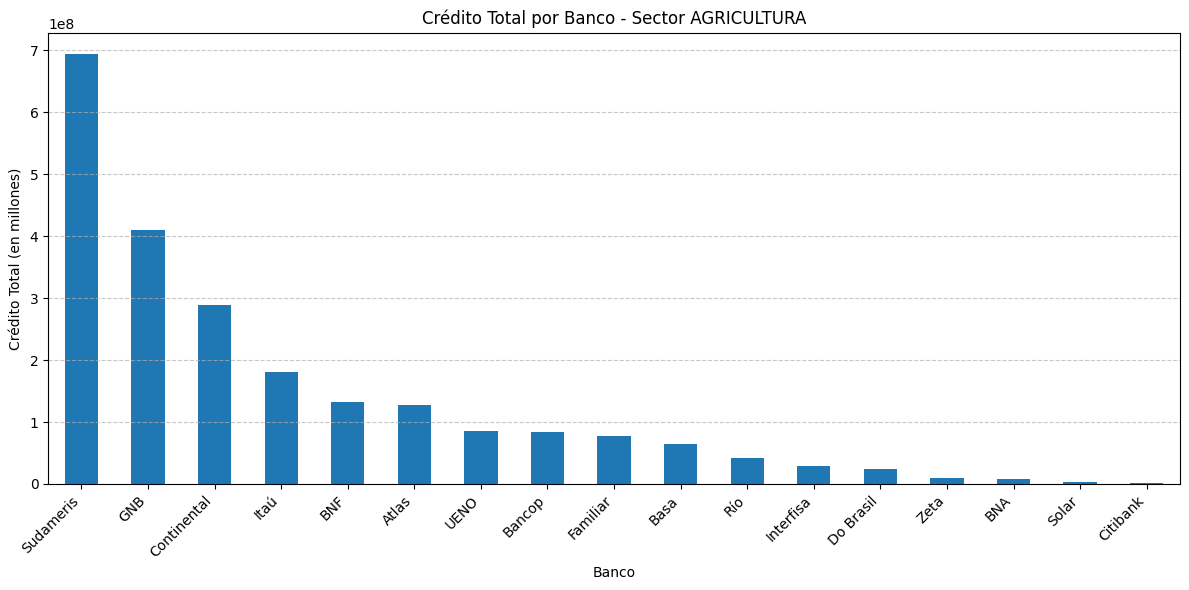

In [7]:
#Grafico de totales por banco
credito_total = df_nuevo.groupby("Banco")["Credito"].sum().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
credito_total.plot(kind='bar')
plt.title("Crédito Total por Banco - Sector AGRICULTURA")
plt.xlabel("Banco")
plt.ylabel("Crédito Total (en millones)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

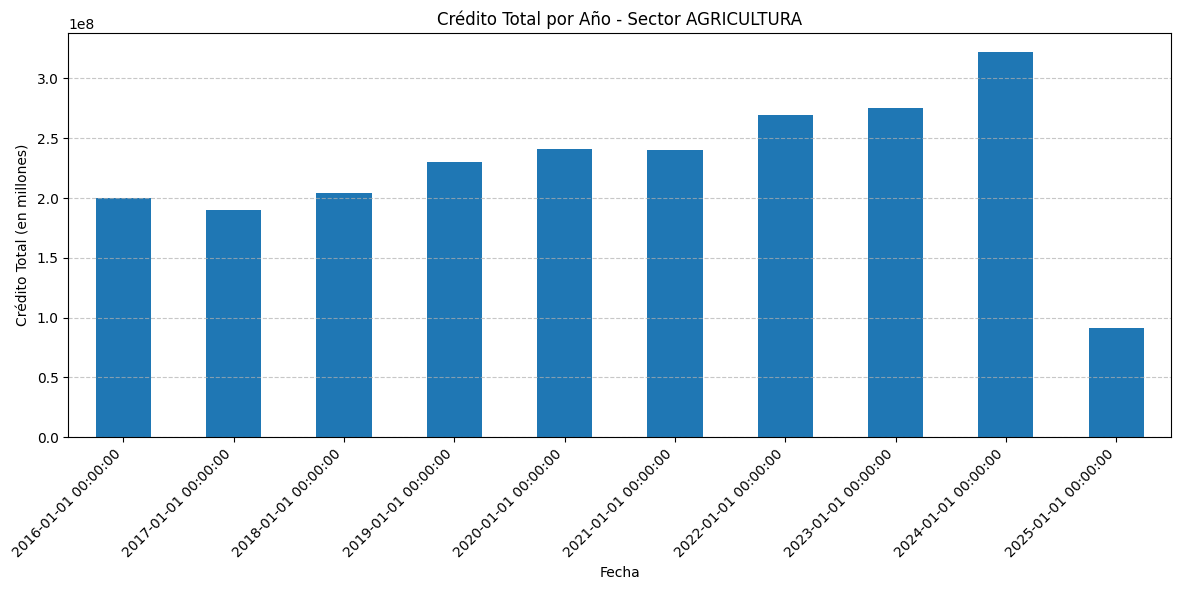

In [8]:
#Grafico de totales por año
df_year = df_nuevo.copy()
df_year['Anho'] = df_year['Fecha'].dt.to_period('Y').dt.to_timestamp()
credito_total = df_year.groupby("Anho")["Credito"].sum()
plt.figure(figsize=(12, 6))
credito_total.plot(kind='bar')
plt.title("Crédito Total por Año - Sector AGRICULTURA")
plt.xlabel("Fecha")
plt.ylabel("Crédito Total (en millones)")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

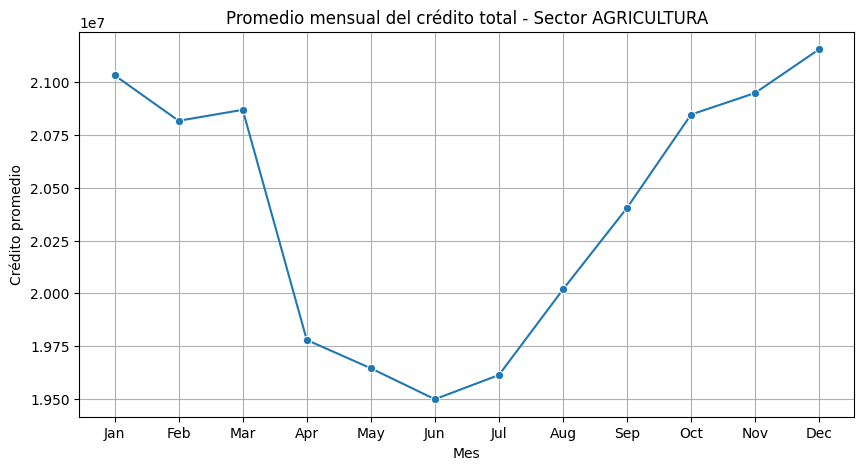

In [9]:
#Graficar promedios mensuales

serie_total = df_nuevo.groupby("Fecha")["Credito"].sum().reset_index()

serie_total["Mes"] = serie_total["Fecha"].dt.month
serie_total["Mes_nombre"] = serie_total["Fecha"].dt.strftime('%b')  # Nombre corto del mes

promedios_mensuales = serie_total.groupby("Mes_nombre")["Credito"].mean().reindex(["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"])

plt.figure(figsize=(10, 5))
sns.lineplot(x=promedios_mensuales.index, y=promedios_mensuales.values, marker="o")
plt.title("Promedio mensual del crédito total - Sector AGRICULTURA")
plt.xlabel("Mes")
plt.ylabel("Crédito promedio")
plt.grid(True)
plt.show()

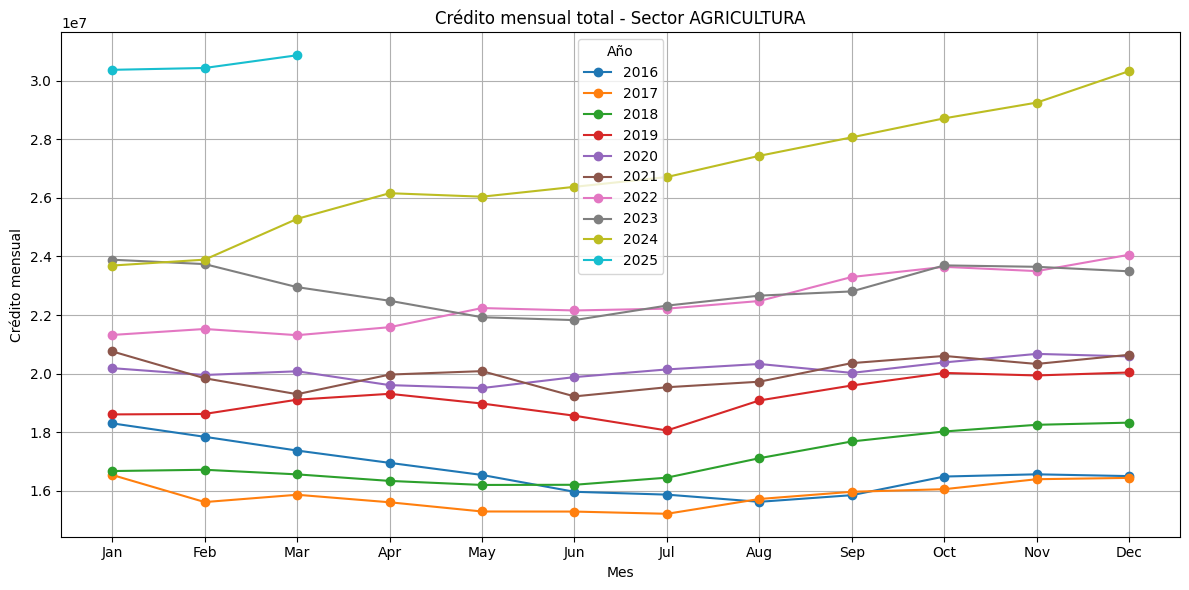

In [10]:
# Crear columna Año
serie_total["Año"] = serie_total["Fecha"].dt.year

# Pivot table: filas = Mes, columnas = Año, valores = suma de crédito
pivot = serie_total.pivot_table(index="Mes", columns="Año", values="Credito", aggfunc='sum')

# Etiquetas de los meses
meses_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# Graficar
plt.figure(figsize=(12,6))
for año in pivot.columns:
    plt.plot(pivot.index, pivot[año], marker='o', label=str(año))

plt.xticks(ticks=range(1,13), labels=meses_labels)
plt.title("Crédito mensual total - Sector AGRICULTURA")
plt.xlabel("Mes")
plt.ylabel("Crédito mensual")
plt.legend(title="Año")
plt.grid(True)
plt.tight_layout()
plt.show()

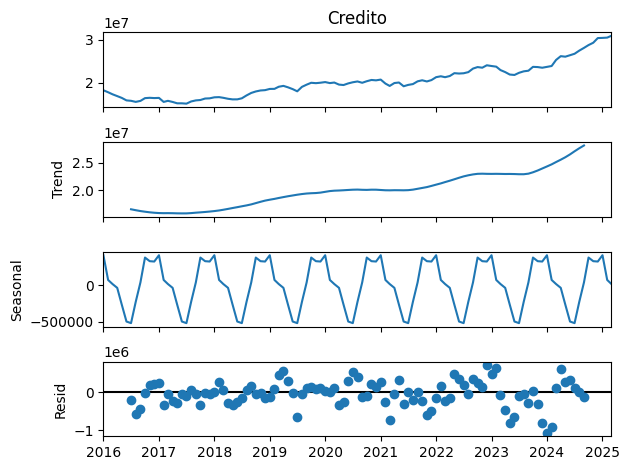

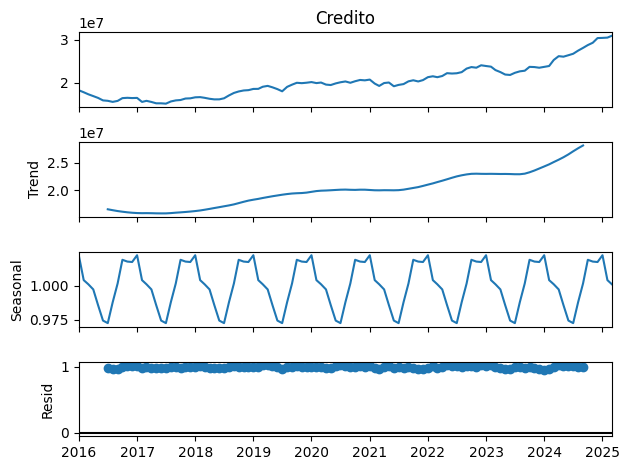

In [11]:
# Sumar todos los créditos por fecha
serie_total = df_nuevo.groupby("Fecha")["Credito"].sum().sort_index()

# Asegurarse de que la frecuencia sea mensual
serie_total = serie_total.asfreq("MS")  # MS = Month Start

# Descomposición aditiva
result = seasonal_decompose(serie_total, model="additive", period=12)

# Mostrar gráfica
result.plot()
plt.tight_layout()
plt.show()

# Prueba modelo multiplicativo
resultado_multi = seasonal_decompose(serie_total, model='multiplicative', period=12)
resultado_multi.plot()
plt.tight_layout()
plt.show()

In [ ]:
'''# Sumar todos los créditos por fecha
serie_total_banco = df_nuevo_banco.groupby("Fecha")["Credito"].sum().sort_index()

# Asegurarse de que la frecuencia sea mensual
serie_total_banco = serie_total_banco.asfreq("MS")  # MS = Month Start

# Descomposición aditiva
result_banco = seasonal_decompose(serie_total_banco, model="additive", period=12)

# Mostrar gráfica
result_banco.plot()
plt.tight_layout()
plt.show()

# Prueba modelo multiplicativo
resultado_multi_banco = seasonal_decompose(serie_total_banco, model='multiplicative', period=12)
resultado_multi_banco.plot()
plt.tight_layout()
plt.show()'''

In [12]:
#Prueba de estacionariedad
adf = adfuller(serie_total.dropna())
print(f"ADF Statistic: {adf[0]:.4f}")
print(f"p-value: {adf[1]:.4f}")

if adf[1] < 0.05:
    print("✅ La serie es estacionaria.")
else:
    print("⚠️ La serie NO es estacionaria.")

ADF Statistic: 1.6093
p-value: 0.9979
⚠️ La serie NO es estacionaria.


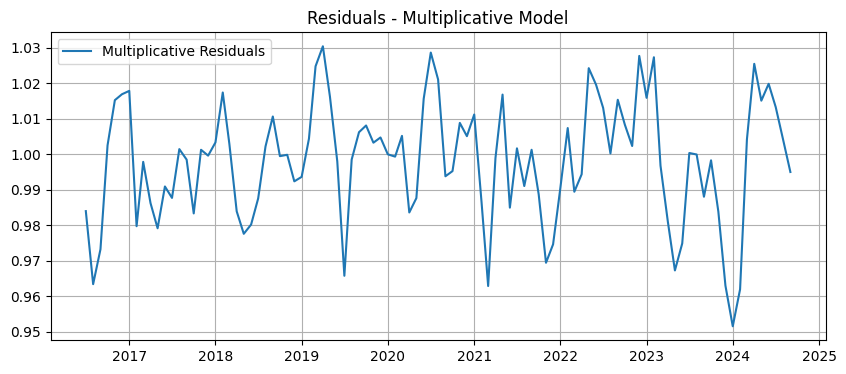

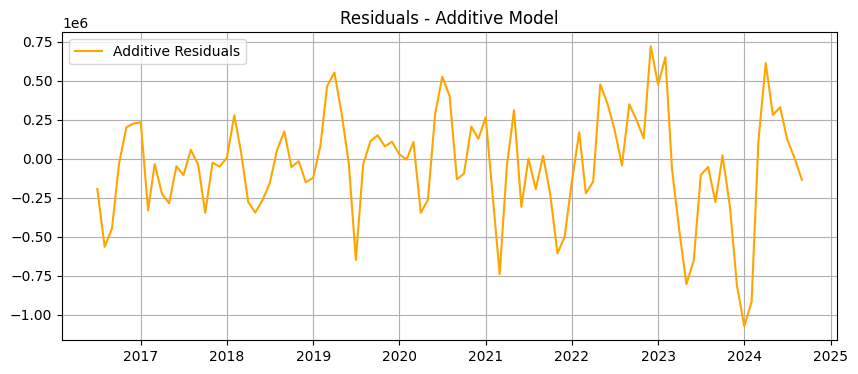

In [13]:
#Calculamos el residuo de la serie aditiva
residuals = result.resid

#Calculamos el residuo de la serie multiplicativa
residual_multi = resultado_multi.resid

plt.figure(figsize=(10, 4))
plt.plot(residual_multi, label='Multiplicative Residuals')
plt.title('Residuals - Multiplicative Model')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(residuals, label='Additive Residuals', color='orange')
plt.title('Residuals - Additive Model')
plt.legend()
plt.grid(True)
plt.show()

--- ADF Test (Additive Residuals) ---
ADF Statistic: -4.2230
p-value: 0.0006
Critical Value (1%): -3.5069
Critical Value (5%): -2.8950
Critical Value (10%): -2.5846

--- ADF Test (Multiplicative Residuals) ---
ADF Statistic: -6.6079
p-value: 0.0000
Critical Value (1%): -3.4996
Critical Value (5%): -2.8918
Critical Value (10%): -2.5829



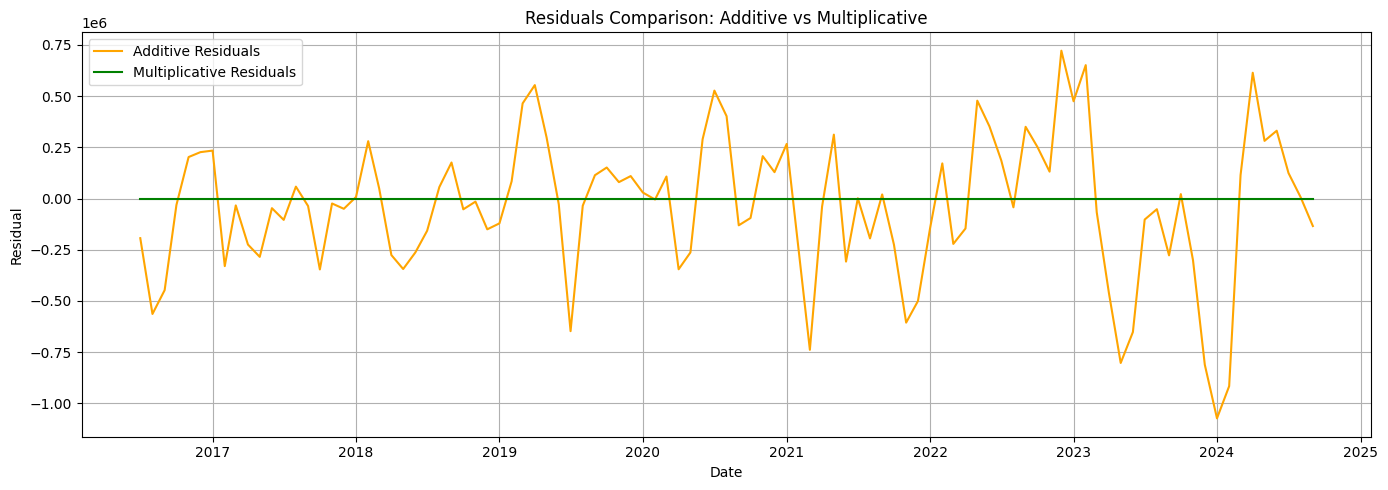

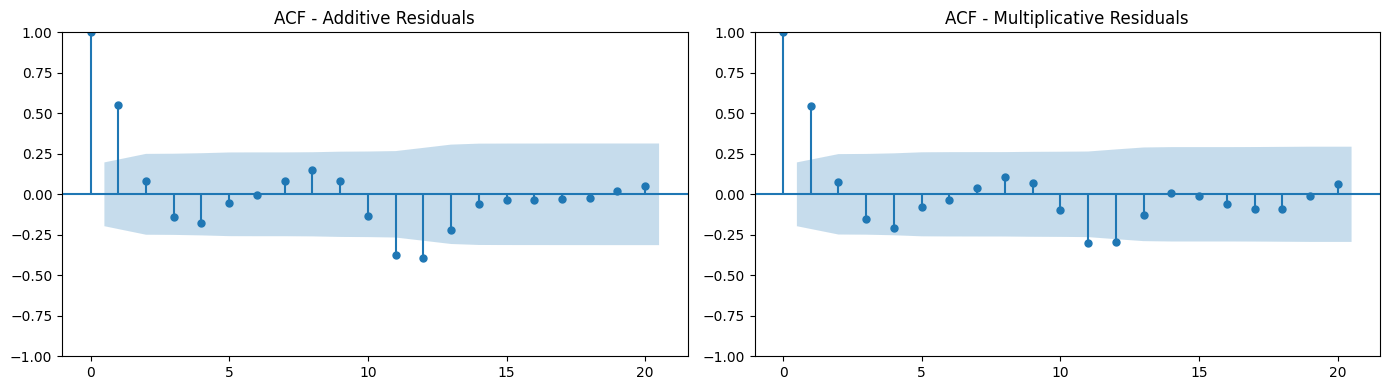

In [14]:
# Prueba ADF
def adf_test(series, label):
    result = adfuller(series.dropna())
    print(f"--- ADF Test ({label}) ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    for key, value in result[4].items():
        print(f"Critical Value ({key}): {value:.4f}")
    print()

# Ejecutar prueba ADF
adf_test(residuals, "Additive Residuals")
adf_test(residual_multi, "Multiplicative Residuals")

# Graficar residuos
plt.figure(figsize=(14, 5))
plt.plot(residuals, label='Additive Residuals', color='orange')
plt.plot(residual_multi, label='Multiplicative Residuals', color='green')
plt.title('Residuals Comparison: Additive vs Multiplicative')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Graficar ACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(residuals.dropna(), ax=axes[0], title='ACF - Additive Residuals')
plot_acf(residual_multi.dropna(), ax=axes[1], title='ACF - Multiplicative Residuals')
plt.tight_layout()
plt.show()

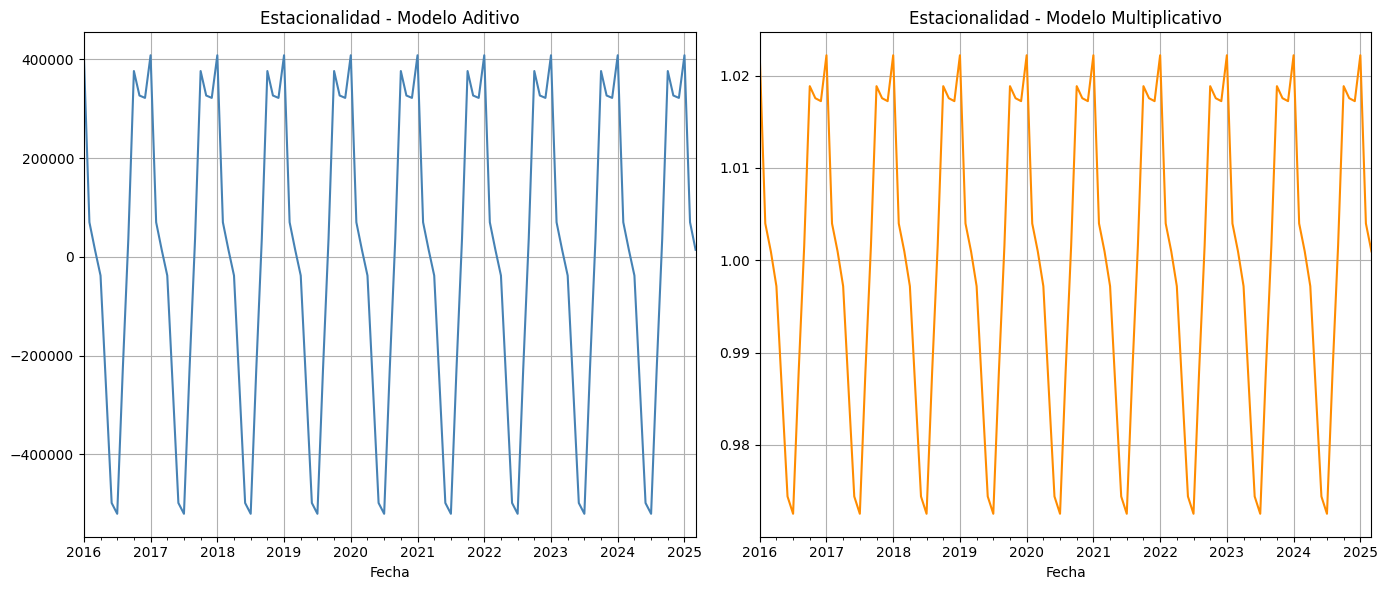

Varianza del componente estacional:
Modelo Aditivo: 97199413743.3165
Modelo Multiplicativo: 0.0003

El modelo multiplicativo muestra una estacionalidad más estable (menor varianza).


In [15]:
# Descomposición aditiva y multiplicativa
decomposition_add = seasonal_decompose(serie_total, model='additive', period=12)
decomposition_mul = seasonal_decompose(serie_total, model='multiplicative', period=12)

# --- Comparación Visual ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
decomposition_add.seasonal.plot(title='Estacionalidad - Modelo Aditivo', color='steelblue')
plt.grid(True)

plt.subplot(1, 2, 2)
decomposition_mul.seasonal.plot(title='Estacionalidad - Modelo Multiplicativo', color='darkorange')
plt.grid(True)

plt.tight_layout()
plt.show()

# --- Comparación Estadística ---
var_add = decomposition_add.seasonal.var()
var_mul = decomposition_mul.seasonal.var()

print("Varianza del componente estacional:")
print(f"Modelo Aditivo: {var_add:.4f}")
print(f"Modelo Multiplicativo: {var_mul:.4f}")

# Interpretación sugerida
if var_mul < var_add:
    print("\nEl modelo multiplicativo muestra una estacionalidad más estable (menor varianza).")
else:
    print("\nEl modelo aditivo muestra una estacionalidad más estable (menor varianza).")

### Dado el aumento de la amplitud estacional a lo largo del tiempo y la mayor estacionariedad tanto de los componentes residuales como de los estacionales, el modelo de **descomposición multiplicativa** proporciona una representación más adecuada de la serie temporal

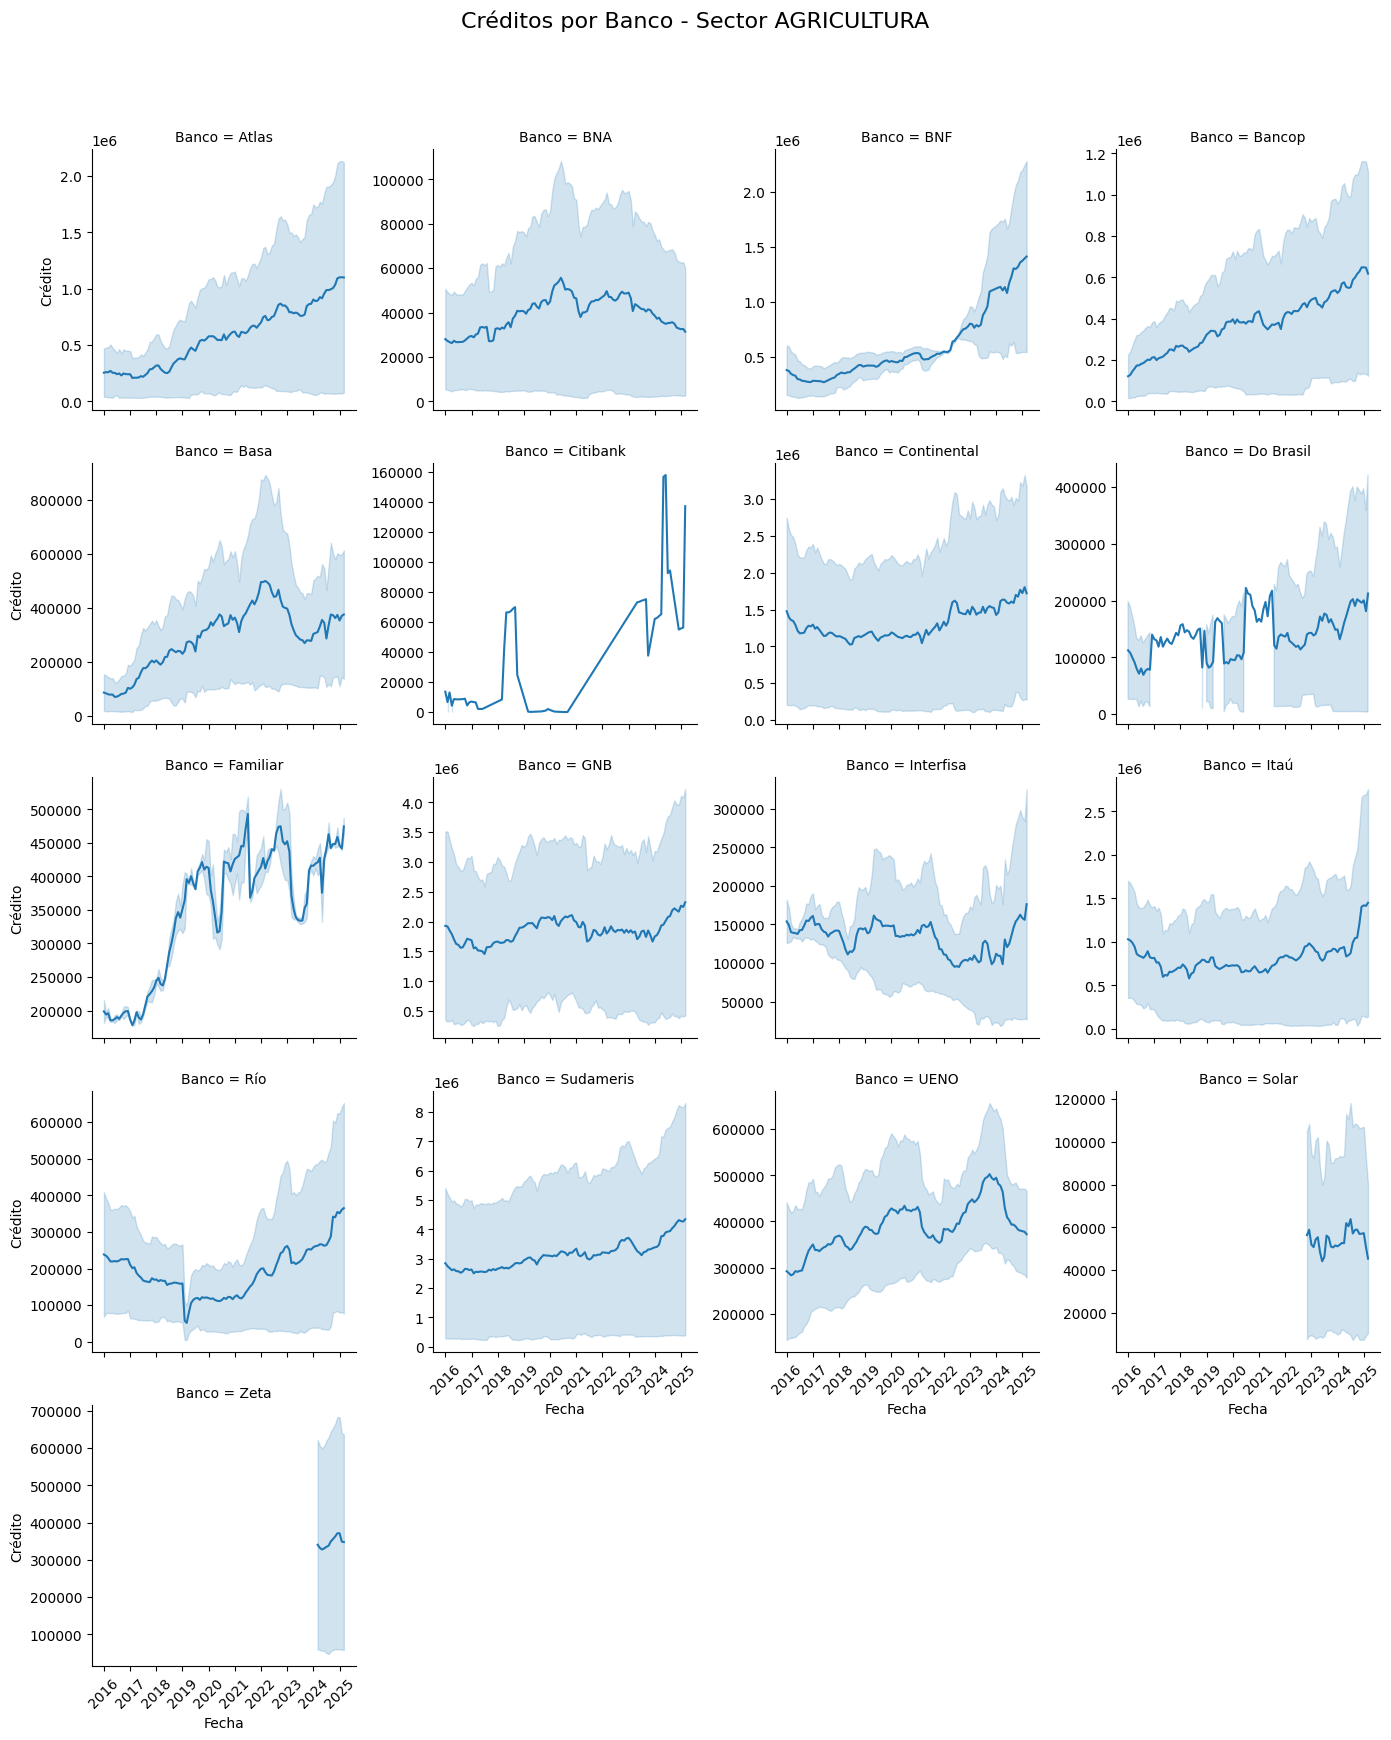

In [16]:
# Crear una gráfica por banco
g = sns.FacetGrid(df_nuevo, col="Banco", col_wrap=4, height=3.5, sharey=False)

# Mapear la serie temporal en cada panel
g.map_dataframe(sns.lineplot, x="Fecha", y="Credito")

# Mejorar etiquetas y rotación de fechas
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=45)

g.set_axis_labels("Fecha", "Crédito")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Créditos por Banco - Sector AGRICULTURA", fontsize=16)

plt.show()

### Analisis por moneda para ver si incluir o agrupar

In [17]:
# Analizar por moneda
df_nuevo.groupby('Moneda')['Credito'].describe()

,count,mean,std,min,25%,50%,75%,max
Moneda,,,,,,,,
ME,1645.0,1.204215e+06,1.582672e+06,93.452548,211105.829696,481625.588882,1.587106e+06,8.308422e+06
MN,1564.0,1.812390e+05,1.802187e+05,0.080919,37417.015328,107926.881986,2.939647e+05,8.146924e+05



Análisis para moneda: ME
                     mean            std        cv
Banco                                             
Citibank     4.125691e+04   41675.084495  1.010136
BNF          6.582943e+05  610450.623282  0.927322
Atlas        1.076758e+06  507683.637532  0.471493
Basa         4.930282e+05  195798.790517  0.397135
Do Brasil    2.140195e+05   80571.093512  0.376466
Río          3.352622e+05  122394.062544  0.365070
Bancop       6.884204e+05  238731.911822  0.346782
Familiar     3.545354e+05   97850.376897  0.275996
BNA          7.506445e+04   15910.725846  0.211961
Itaú         1.530175e+06  315587.601005  0.206243
Interfisa    1.947235e+05   39068.496264  0.200636
Continental  2.447575e+06  372120.240709  0.152036
Sudameris    5.919640e+06  870526.684372  0.147057
UENO         5.118061e+05   59007.550701  0.115293
Solar        9.850684e+04    9972.830624  0.101240
GNB          3.228321e+06  318138.589424  0.098546
Zeta         6.375649e+05   27882.500878  0.043733


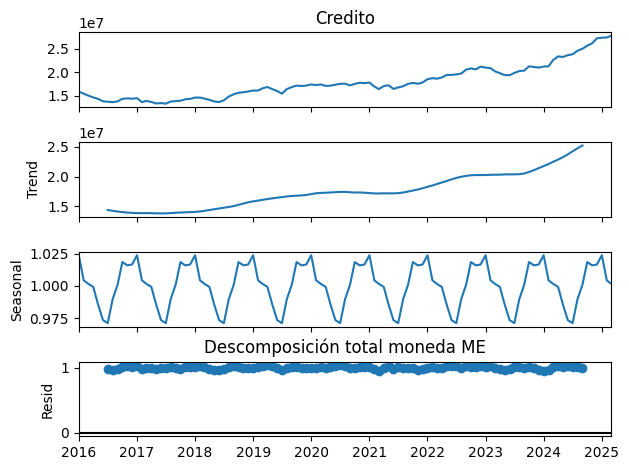


Análisis para moneda: MN
                      mean            std        cv
Banco                                              
Citibank        284.118645     417.399465  1.469103
Itaú          97237.760077   76036.567746  0.781965
Do Brasil     14521.269319    9121.626844  0.628156
Bancop        60888.899530   32182.424412  0.528543
Interfisa     71030.166654   35251.435450  0.496288
Basa          85066.507842   39713.373300  0.466851
Atlas         69428.763786   32078.296989  0.462032
Río           44541.822223   19829.784138  0.445195
GNB          470260.308541  153325.739483  0.326044
BNA            3784.725949    1226.963993  0.324188
Continental  161245.106283   49466.702049  0.306780
Familiar     346155.383936  100836.242496  0.291303
UENO         264221.504363   53166.754323  0.201220
Sudameris    326437.335742   60985.193276  0.186821
Solar          9667.602620    1497.824582  0.154932
BNF          535055.074607   66941.946215  0.125112
Zeta          56470.823128    3973.413

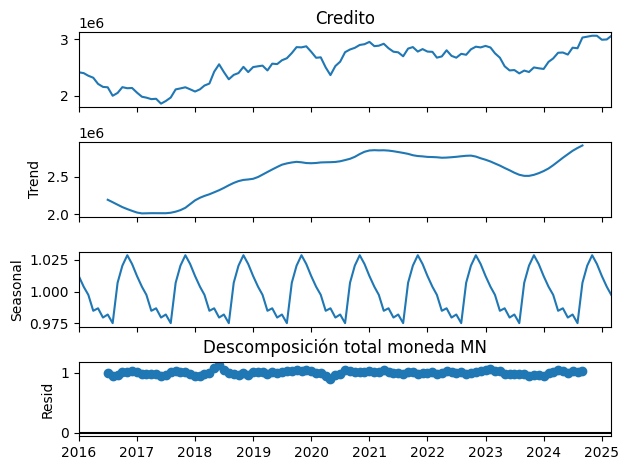

In [18]:
# Coeficiente de variación (CV) por banco y moneda

for moneda in df_nuevo['Moneda'].unique():
    print(f"\nAnálisis para moneda: {moneda}")
    df_moneda = df_nuevo[df_nuevo['Moneda'] == moneda]
    
    # calcular CV
    cv_por_banco = df_moneda.groupby("Banco")["Credito"].agg(['mean', 'std'])
    cv_por_banco["cv"] = cv_por_banco["std"] / cv_por_banco["mean"]
    cv_por_banco = cv_por_banco.sort_values("cv", ascending=False)
    print(cv_por_banco.head(20))
    
    # descomposición para total moneda
    serie_total = df_moneda.groupby("Fecha")["Credito"].sum()
    serie_total.index = pd.to_datetime(serie_total.index)
    decomp_total = seasonal_decompose(serie_total, model="multiplicative", period=12)
    decomp_total.plot()
    plt.title(f"Descomposición total moneda {moneda}")
    plt.show()

In [ ]:
# === Con moneda (MN y ME separados en df pero agrupados para el analisis) ===
cv_por_banco_con_moneda = df_nuevo.groupby("Banco")["Credito"].agg(['mean', 'std'])
cv_por_banco_con_moneda["cv"] = cv_por_banco_con_moneda["std"] / cv_por_banco_con_moneda["mean"]
cv_por_banco_con_moneda = cv_por_banco_con_moneda.sort_values("cv", ascending=False)
print(cv_por_banco_con_moneda.head(20))


                     mean           std        cv
Banco                                            
Citibank     3.489906e+04  4.106752e+04  1.176751
Atlas        5.730932e+05  6.193756e+05  1.080759
Bancop       3.746547e+05  3.574597e+05  0.954105
BNA          3.942459e+04  3.745263e+04  0.949982
Itaú         8.137066e+05  7.537244e+05  0.926285
Sudameris    3.123039e+06  2.869741e+06  0.918894
Continental  1.304410e+06  1.175960e+06  0.901526
Río          1.899020e+05  1.699329e+05  0.894845
Basa         2.890474e+05  2.483210e+05  0.859101
Zeta         3.470179e+05  2.969428e+05  0.855699
Do Brasil    1.368655e+05  1.161500e+05  0.848644
Solar        5.408722e+04  4.536162e+04  0.838675
GNB          1.849291e+06  1.404425e+06  0.759440
BNF          5.966747e+05  4.376374e+05  0.733461
Interfisa    1.328769e+05  7.225345e+04  0.543763
UENO         3.880138e+05  1.361392e+05  0.350862
Familiar     3.503454e+05  9.921840e+04  0.283202


In [20]:
# === Sin moneda (agregado total por banco) ===
cv_por_banco_sin_moneda = df_nuevo_banco.groupby("Banco")["Credito"].agg(['mean', 'std'])
cv_por_banco_sin_moneda["cv"] = cv_por_banco_sin_moneda["std"] / cv_por_banco_sin_moneda["mean"]
cv_por_banco_sin_moneda = cv_por_banco_sin_moneda.sort_values("cv", ascending=False)
print(cv_por_banco_sin_moneda.head(20))

                     mean            std        cv
Banco                                             
Citibank     3.748417e+04   41414.395410  1.104850
BNF          1.193349e+06  633641.119312  0.530977
Atlas        1.146186e+06  526569.369769  0.459410
Basa         5.780947e+05  229117.466590  0.396332
Do Brasil    2.231770e+05   82042.444219  0.367611
Bancop       7.493093e+05  262299.063589  0.350054
Río          3.798040e+05  130652.785921  0.344001
Familiar     7.006908e+05  193113.855524  0.275605
Itaú         1.627413e+06  328622.582662  0.201929
BNA          7.884918e+04   15434.912884  0.195752
Continental  2.608821e+06  394187.977614  0.151098
Interfisa    2.657537e+05   38585.397603  0.145192
Sudameris    6.246078e+06  905375.039675  0.144951
UENO         7.760276e+05  101940.224716  0.131362
GNB          3.698581e+06  375525.584786  0.101532
Solar        1.081744e+05    9683.865047  0.089521
Zeta         6.940357e+05   29747.440082  0.042862


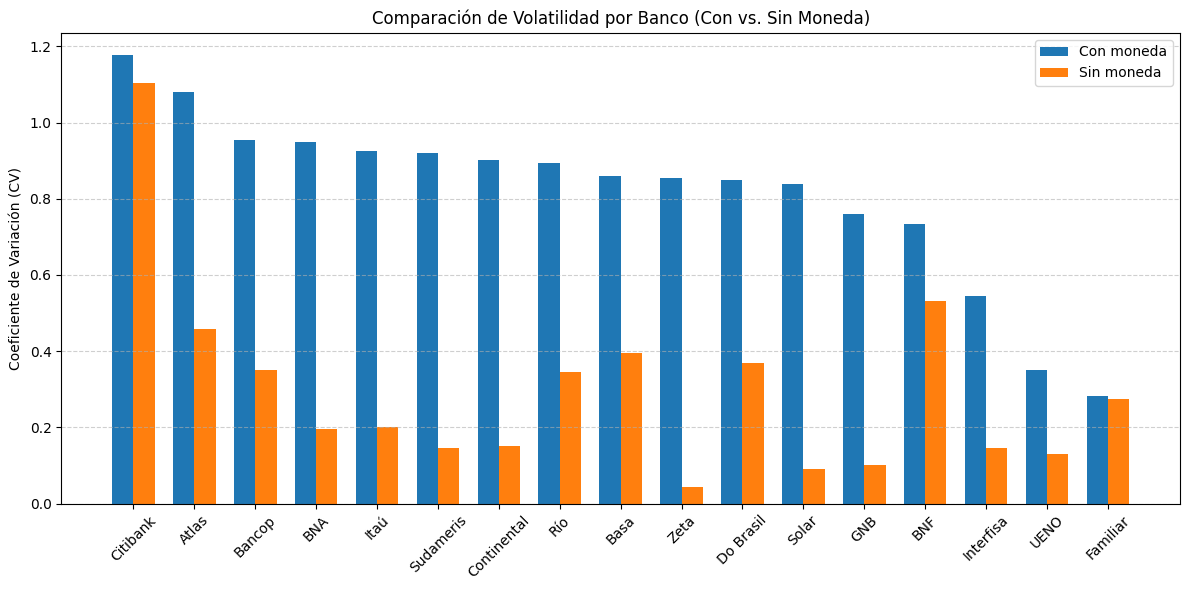

In [21]:
# Unir los dos DataFrames para facilitar el gráfico
comparacion_cv = cv_por_banco_con_moneda[["cv"]].rename(columns={"cv": "CV_con_moneda"}).copy()
comparacion_cv["CV_sin_moneda"] = cv_por_banco_sin_moneda["cv"]

# CV con moneda (puedes cambiar por CV_sin_moneda si prefieres ese criterio)
top_bancos = comparacion_cv.sort_values("CV_con_moneda", ascending=False).head(20)

# Gráfico de barras comparativo
x = range(len(top_bancos))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x, top_bancos["CV_con_moneda"], width=width, label="Con moneda")
plt.bar([i + width for i in x], top_bancos["CV_sin_moneda"], width=width, label="Sin moneda")

plt.xticks([i + width / 2 for i in x], top_bancos.index, rotation=45)
plt.ylabel("Coeficiente de Variación (CV)")
plt.title("Comparación de Volatilidad por Banco (Con vs. Sin Moneda)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

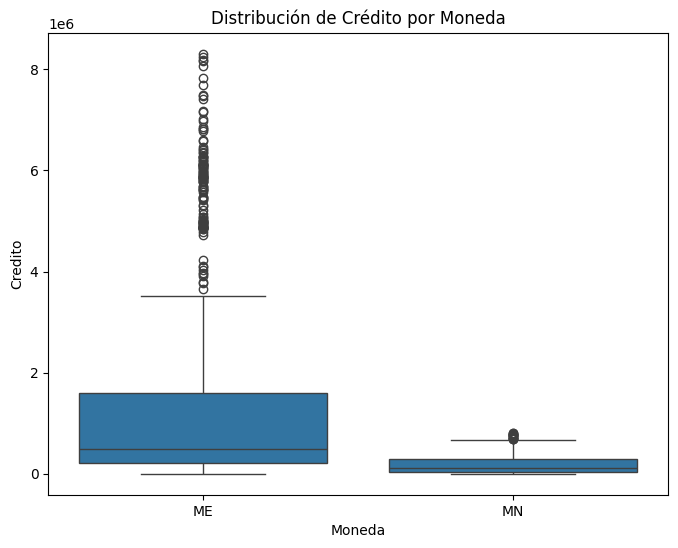

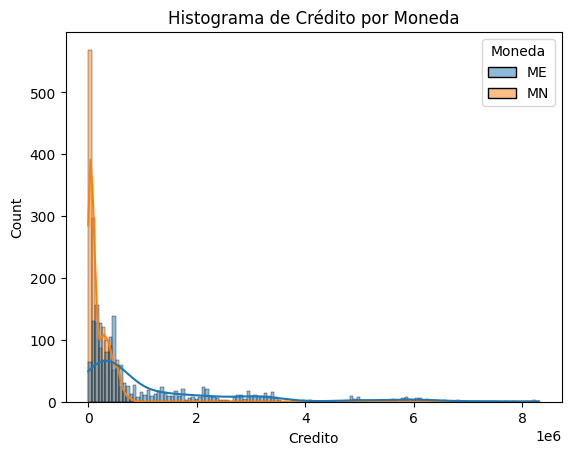

In [22]:
# Box plot de crédito por moneda
plt.figure(figsize=(8, 6))
sns.boxplot(x='Moneda', y='Credito', data=df_nuevo)
plt.title('Distribución de Crédito por Moneda')
plt.show()

# histogramas superpuestos/facetados
sns.histplot(data=df_nuevo, x='Credito', hue='Moneda', kde=True)
plt.title('Histograma de Crédito por Moneda')
plt.show()

### Test de ANOVA - (Analisis de Varianza)

Si el p-value es bajo, indica que hay una diferencia estadísticamente significativa entre las medias de Credito para las diferentes monedas. 

Esto refuerza la idea de que la moneda es una variable importante y no debería agruparse sino analizarse de manera separada.

In [23]:
# Test de ANOVA para comparar medias entre grupos
import statsmodels.formula.api as smf

# 'Credito ~ C(Moneda)' indica que Moneda es una variable categórica
model_anova = smf.ols('Credito ~ C(Moneda)', data=df_nuevo).fit()
print(model_anova.summary()) # Te mostrará el F-statistic para la variable Moneda

                            OLS Regression Results                            
Dep. Variable:                Credito   R-squared:                       0.168
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     645.4
Date:                Sat, 24 May 2025   Prob (F-statistic):          6.88e-130
Time:                        09:47:58   Log-Likelihood:                -49307.
No. Observations:                3209   AIC:                         9.862e+04
Df Residuals:                    3207   BIC:                         9.863e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.204e+06   2.81e+04     

### Prueba de LEVENE
**True:** Si la prueba muestra diferencias estadísticamente significativas de varianza en varios bancos (p < 0.05), indica que la volatilidad del crédito cambia entre MN y ME.

In [24]:
# Test de Levene para comparar varianzas entre grupos

# Crear lista de resultados
resultados_levene = []

# Iterar por cada banco único
for banco in df_nuevo["Banco"].unique():
    grupo = df_nuevo[df_nuevo["Banco"] == banco]

    # Asegurarse de que haya datos para ambas monedas
    if grupo["Moneda"].nunique() == 2:
        mn = grupo[grupo["Moneda"] == "MN"]["Credito"]
        me = grupo[grupo["Moneda"] == "ME"]["Credito"]

        # Ejecutar prueba de Levene
        stat, p = levene(mn, me)

        resultados_levene.append({
            "Banco": banco,
            "Estadístico Levene": stat,
            "p-valor": p,
            "Significativo": p < 0.05
        })

# Convertir a DataFrame
df_levene = pd.DataFrame(resultados_levene)

# Ordenar por p-valor ascendente (más significativos primero)
df_levene = df_levene.sort_values("p-valor")

# Mostrar resultados significativos
print("Bancos con diferencia significativa de varianzas entre MN y ME:")
print(df_levene[df_levene["Significativo"] == True])


Bancos con diferencia significativa de varianzas entre MN y ME:
          Banco  Estadístico Levene       p-valor  Significativo
0         Atlas          224.499879  1.893564e-35           True
1           BNA          199.005619  1.294457e-32           True
3        Bancop          173.585691  1.311367e-29           True
12          Río          156.961881  1.554402e-27           True
13    Sudameris          120.885333  1.075083e-22           True
4          Basa          114.478135  8.819010e-22           True
6   Continental          107.575328  8.920426e-21           True
7     Do Brasil           73.828443  4.111469e-15           True
2           BNF           54.525761  3.133381e-12           True
11         Itaú           47.537919  5.634907e-11           True
15        Solar           61.592299  1.375375e-10           True
9           GNB           26.267881  6.498113e-07           True
16         Zeta           19.039452  2.096301e-04           True
5      Citibank           

In [25]:
# Filtramos por cada moneda
mn = df_nuevo[df_nuevo['Moneda'] == 'MN']['Credito']
me = df_nuevo[df_nuevo['Moneda'] == 'ME']['Credito']

# Prueba t de medias (asume varianzas distintas)
t_stat, p_value = ttest_ind(mn, me, equal_var=False)

print(f"T-statistic: {t_stat:.3f}, p-value: {p_value:.4f}")
if p_value < 0.05:
    print("Resultado: Diferencia significativa entre MN y ME.")
else:
    print("Resultado: No hay diferencia significativa entre MN y ME.")

T-statistic: -26.039, p-value: 0.0000
Resultado: Diferencia significativa entre MN y ME.


### Comparación visual por bancos con mayores colocaciones en el Sector 

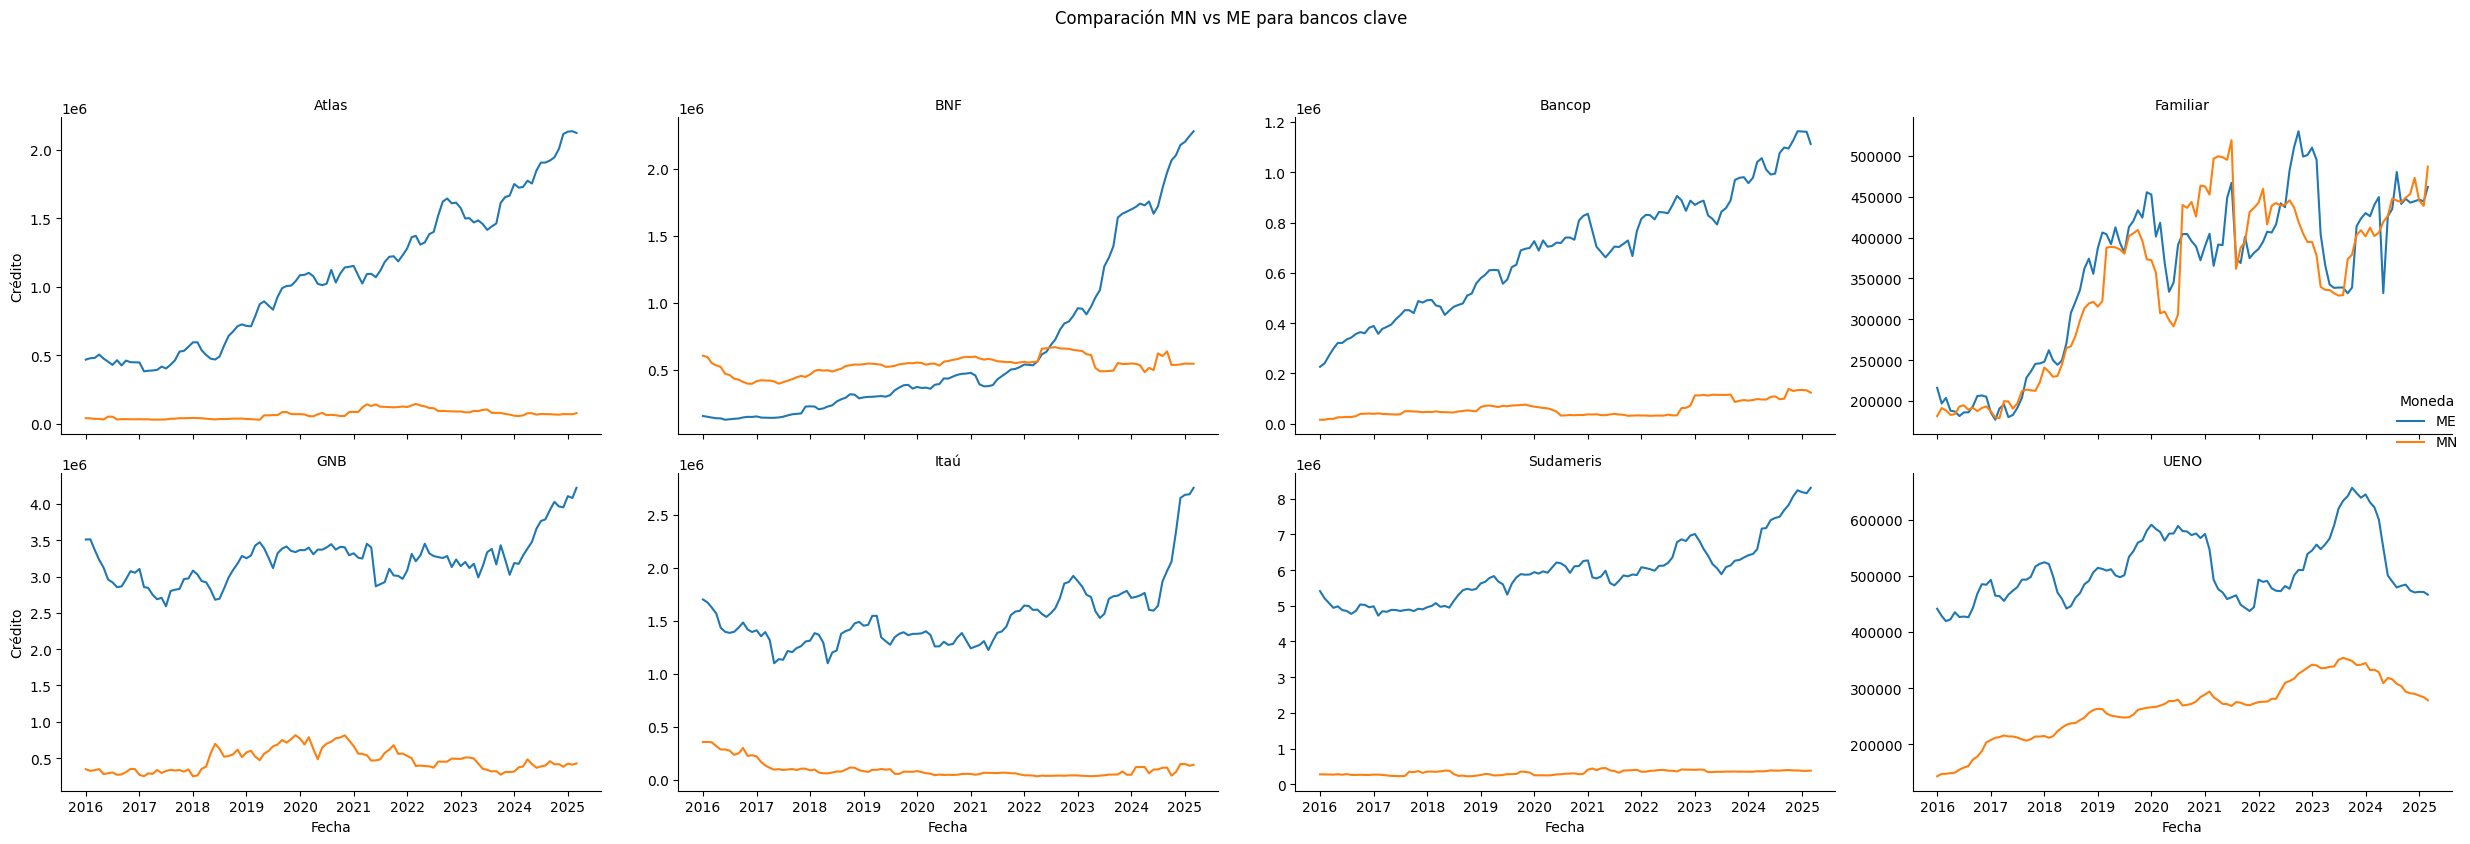

In [26]:
# Bancos clave
bancos_clave = ['Sudameris', 'GNB', 'Itaú', 'BNF', 'Atlas', 'UENO', 'Bancop', 'Familiar']

# Filtramos
df_clave = df_nuevo[df_nuevo['Banco'].isin(bancos_clave)]

# Graficamos
g = sns.FacetGrid(df_clave, col="Banco", hue="Moneda", height=4, aspect=1.5,col_wrap=4, sharey=False)
g.map(sns.lineplot, "Fecha", "Credito")
g.add_legend()
g.set_titles("{col_name}")
g.set_axis_labels("Fecha", "Crédito")

plt.suptitle("Comparación MN vs ME para bancos clave", y=1.05)
plt.tight_layout()
plt.show()

In [27]:
# Regresión lineal para comparar modelos con y sin moneda

# Convertimos fecha a ordinal
df_nuevo["FechaOrd"] = pd.to_datetime(df_nuevo["Fecha"]).map(lambda x: x.toordinal())
df_nuevo_banco["FechaOrd"] = pd.to_datetime(df_nuevo_banco["Fecha"]).map(lambda x: x.toordinal())

# Codificamos Moneda
df_nuevo["Moneda_cod"] = df_nuevo["Moneda"].map({"MN": 0, "ME": 1})

# Modelo sin moneda
X1 = sm.add_constant(df_nuevo_banco[["FechaOrd"]])
modelo_sin = sm.OLS(df_nuevo_banco["Credito"], X1).fit()

# Modelo con moneda
X2 = sm.add_constant(df_nuevo[["FechaOrd", "Moneda_cod"]])
modelo_con = sm.OLS(df_nuevo["Credito"], X2).fit()

# Resultados
print("=== Modelo sin Moneda ===")
print(modelo_sin.summary())
print("\n=== Modelo con Moneda ===")
print(modelo_con.summary())

# Comparar R^2
print(f"\nR² sin Moneda: {modelo_sin.rsquared:.4f}")
print(f"R² con Moneda: {modelo_con.rsquared:.4f}")

=== Modelo sin Moneda ===
                            OLS Regression Results                            
Dep. Variable:                Credito   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     22.53
Date:                Sat, 24 May 2025   Prob (F-statistic):           2.25e-06
Time:                        09:49:43   Log-Likelihood:                -25968.
No. Observations:                1650   AIC:                         5.194e+04
Df Residuals:                    1648   BIC:                         5.195e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.424e+08   3.

### Considerando la magnitud del impacto de la Moneda y la mejora en el R² para el analisis de los datos con moneda, es mejor analizar series separadas para cada moneda (MN y ME)

In [28]:
# 1. Escalar FechaOrd
fecha_min = df_nuevo["Fecha"].min()
df_nuevo["FechaOrd_scaled"] = pd.to_datetime(df_nuevo["Fecha"]).map(lambda x: (x - fecha_min).days)

# 2. Codificar Moneda como dummy
df_nuevo["Moneda_cod"] = df_nuevo["Moneda"].map({"MN": 0, "ME": 1})

# 3. Separar DataFrames por moneda
df_mn = df_nuevo.query("Moneda == 'MN'").sort_values("Fecha").copy()
df_me = df_nuevo.query("Moneda == 'ME'").sort_values("Fecha").copy()

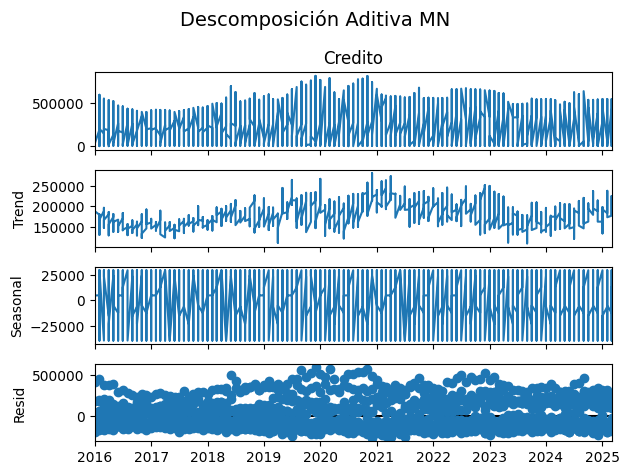

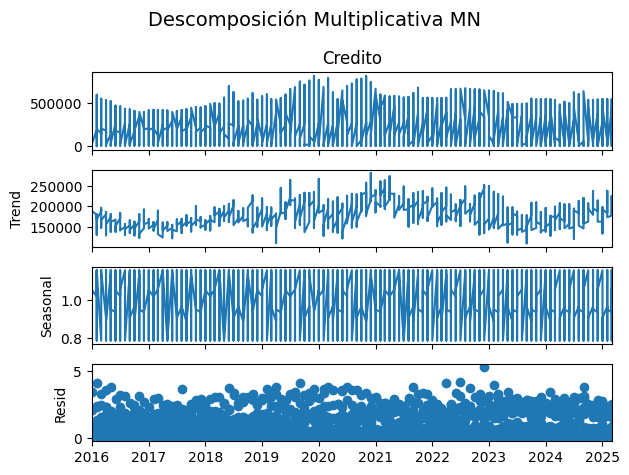

In [29]:
# Descomposicion de la serie temporal para la moneda nacional (MN)
# Crear index de fecha
df_mn = df_mn.copy()
df_mn['Fecha'] = pd.to_datetime(df_mn['Fecha'])
df_mn.set_index('Fecha', inplace=True)

# Descomposición aditiva
decomp_add = seasonal_decompose(df_mn['Credito'], model='additive', period=12)

# Descomposición multiplicativa
decomp_mult = seasonal_decompose(df_mn['Credito'], model='multiplicative', period=12)

# Graficar modelo aditivo
decomp_add.plot()
plt.suptitle('Descomposición Aditiva MN', fontsize=14)
plt.tight_layout()
plt.show()

# Graficar modelo multiplicativo
decomp_mult.plot()
plt.suptitle('Descomposición Multiplicativa MN', fontsize=14)
plt.tight_layout()
plt.show()

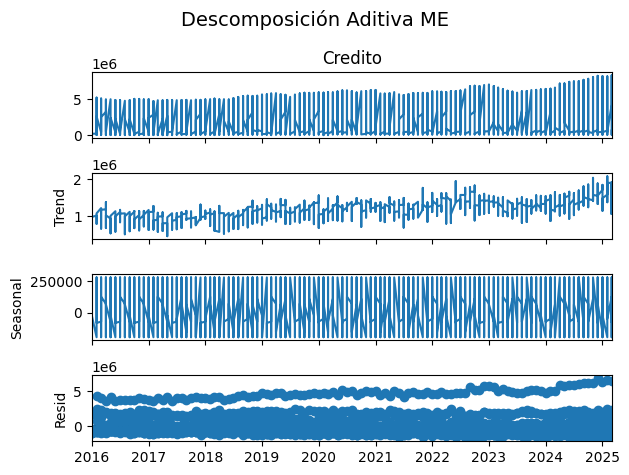

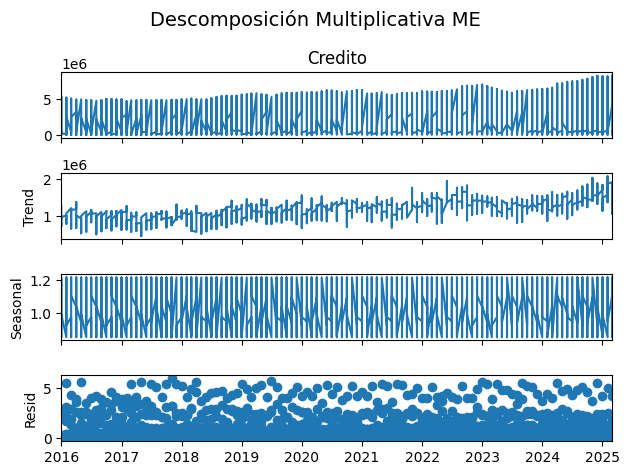

In [30]:
# Descomposicion de la serie temporal para la moneda extranjera (ME)
df_me = df_me.copy()
df_me['Fecha'] = pd.to_datetime(df_me['Fecha'])
df_me.set_index('Fecha', inplace=True)

# Descomposición aditiva
decomp_add = seasonal_decompose(df_me['Credito'], model='additive', period=12)

# Descomposición multiplicativa
decomp_mult = seasonal_decompose(df_me['Credito'], model='multiplicative', period=12)

# Graficar modelo aditivo
decomp_add.plot()
plt.suptitle('Descomposición Aditiva ME', fontsize=14)
plt.tight_layout()
plt.show()

# Graficar modelo multiplicativo
decomp_mult.plot()
plt.suptitle('Descomposición Multiplicativa ME', fontsize=14)
plt.tight_layout()
plt.show()


--- Análisis de modelo para Moneda Nacional (MN) ---
Aditivo → Varianza: 6494541589.70, p-valor Shapiro: 0.0589
Multiplicativo → Varianza: 0.00, p-valor Shapiro: 0.0250
✅ Mejor ajuste: Modelo Multiplicativo


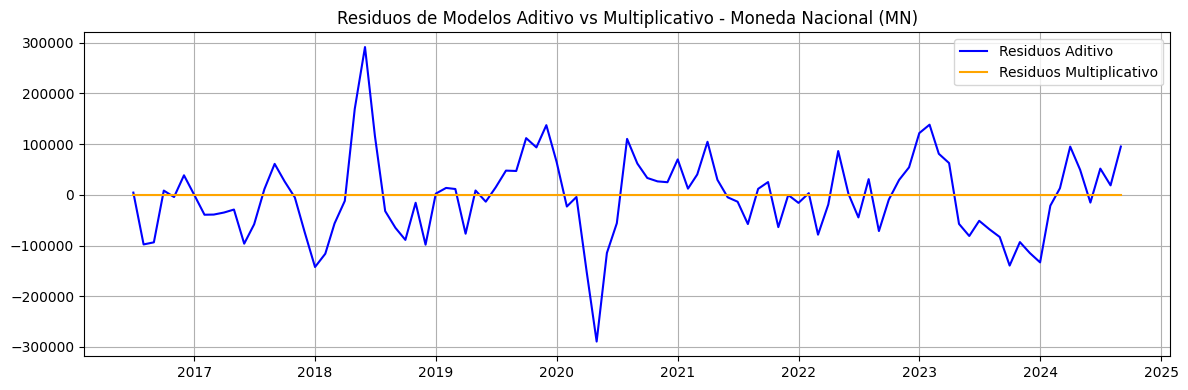


--- Análisis de modelo para Moneda Extranjera (ME) ---
Aditivo → Varianza: 108326554440.87, p-valor Shapiro: 0.1043
Multiplicativo → Varianza: 0.00, p-valor Shapiro: 0.1318
✅ Mejor ajuste: Modelo Multiplicativo


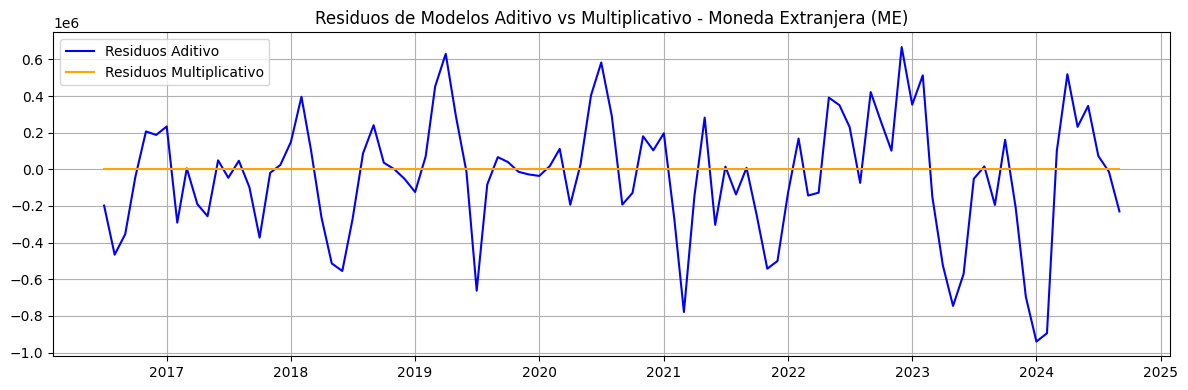

In [31]:
# test de normalidad Shapiro-Wilk para comparar residuos

def preparar_serie(df):
    df = df.copy()

    # Asegurar que 'Fecha' esté como columna y en formato datetime
    if 'Fecha' not in df.columns:
        df.reset_index(inplace=True)
    df['Fecha'] = pd.to_datetime(df['Fecha'])

    # Agrupar por mes para evitar duplicados
    df = df.groupby('Fecha', as_index=False)['Credito'].sum()

    # Establecer el índice y aplicar frecuencia mensual
    df = df.set_index('Fecha').sort_index()
    df = df.asfreq('MS')  # 'MS' = month start
    return df['Credito']

def comparar_modelos(df, nombre):
    serie = preparar_serie(df)

    print(f"\n--- Análisis de modelo para {nombre} ---")

    modelo_ad = seasonal_decompose(serie, model='additive', period=12)
    modelo_mul = seasonal_decompose(serie, model='multiplicative', period=12)

    residuos_ad = modelo_ad.resid.dropna()
    residuos_mul = modelo_mul.resid.dropna()

    # Varianza y prueba de normalidad (Shapiro)
    var_ad = residuos_ad.var()
    var_mul = residuos_mul.var()
    _, p_ad = shapiro(residuos_ad)
    _, p_mul = shapiro(residuos_mul)

    print(f"Aditivo → Varianza: {var_ad:.2f}, p-valor Shapiro: {p_ad:.4f}")
    print(f"Multiplicativo → Varianza: {var_mul:.2f}, p-valor Shapiro: {p_mul:.4f}")

    if var_ad < var_mul:
        print("✅ Mejor ajuste: Modelo Aditivo")
    else:
        print("✅ Mejor ajuste: Modelo Multiplicativo")

    # Plot de residuos
    plt.figure(figsize=(12, 4))
    plt.plot(residuos_ad, label='Residuos Aditivo', color='blue')
    plt.plot(residuos_mul, label='Residuos Multiplicativo', color='orange')
    plt.title(f'Residuos de Modelos Aditivo vs Multiplicativo - {nombre}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Ejecutar para ambas monedas
comparar_modelos(df_mn, "Moneda Nacional (MN)")
comparar_modelos(df_me, "Moneda Extranjera (ME)")

In [32]:
# --- Función para aplicar la prueba ADF ---
def adf_test(series, label):
    # .dropna() es importante porque seasonal_decompose puede dejar NaN al inicio/final
    result = adfuller(series.dropna())
    print(f"--- ADF Test ({label}) ---")
    print(f"ADF Statistic         : {result[0]:.4f}")
    print(f"p-value               : {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"   {key}: {value:.4f}")
    if result[1] < 0.05:
        print("=> La serie es probablemente estacionaria ✅\n")
    else:
        print("=> La serie NO es estacionaria ❌\n")

# ADF para la serie total de créditos por fecha por moneda
serie_mn = df_mn.groupby(df_mn.index)['Credito'].sum()
adf_test(serie_mn, 'Credito Total MN por Fecha')

serie_me = df_me.groupby(df_me.index)['Credito'].sum()
adf_test(serie_me, 'Credito Total ME por Fecha')

--- ADF Test (Credito Total MN por Fecha) ---
ADF Statistic         : -1.1362
p-value               : 0.7004
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie NO es estacionaria ❌

--- ADF Test (Credito Total ME por Fecha) ---
ADF Statistic         : 1.8357
p-value               : 0.9984
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie NO es estacionaria ❌



In [33]:
# Logaritmo MN
serie_log_mn = np.log(serie_mn[serie_mn > 0])
adf_test(serie_log_mn, 'MN Log(Credito)')

# Primera diferencia
serie_diff_mn = serie_mn.diff()
adf_test(serie_diff_mn, 'MN Diferencia(Credito)')

# Diferencia del logaritmo (crecimiento relativo)
serie_log_diff_mn = serie_log_mn.diff()
adf_test(serie_log_diff_mn, 'MN Diferencia+Log(Credito)')

--- ADF Test (MN Log(Credito)) ---
ADF Statistic         : -1.1830
p-value               : 0.6809
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie NO es estacionaria ❌

--- ADF Test (MN Diferencia(Credito)) ---
ADF Statistic         : -8.8959
p-value               : 0.0000
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie es probablemente estacionaria ✅

--- ADF Test (MN Diferencia+Log(Credito)) ---
ADF Statistic         : -8.8361
p-value               : 0.0000
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie es probablemente estacionaria ✅



In [34]:
# Logaritmo ME
serie_log_me = np.log(serie_me[serie_me > 0])
adf_test(serie_log_me, 'ME Log(Credito)')

# Primera diferencia
serie_diff_me = serie_me.diff()
adf_test(serie_diff_me, 'ME Diferencia(Credito)')

# Diferencia del logaritmo (crecimiento relativo)
serie_log_diff_me = serie_log_me.diff()
adf_test(serie_log_diff_me, 'ME Diferencia+Log(Credito)')

--- ADF Test (ME Log(Credito)) ---
ADF Statistic         : 1.0015
p-value               : 0.9943
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie NO es estacionaria ❌

--- ADF Test (ME Diferencia(Credito)) ---
ADF Statistic         : -7.9673
p-value               : 0.0000
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie es probablemente estacionaria ✅

--- ADF Test (ME Diferencia+Log(Credito)) ---
ADF Statistic         : -8.2091
p-value               : 0.0000
Critical Values:
   1%: -3.4918
   5%: -2.8884
   10%: -2.5811
=> La serie es probablemente estacionaria ✅



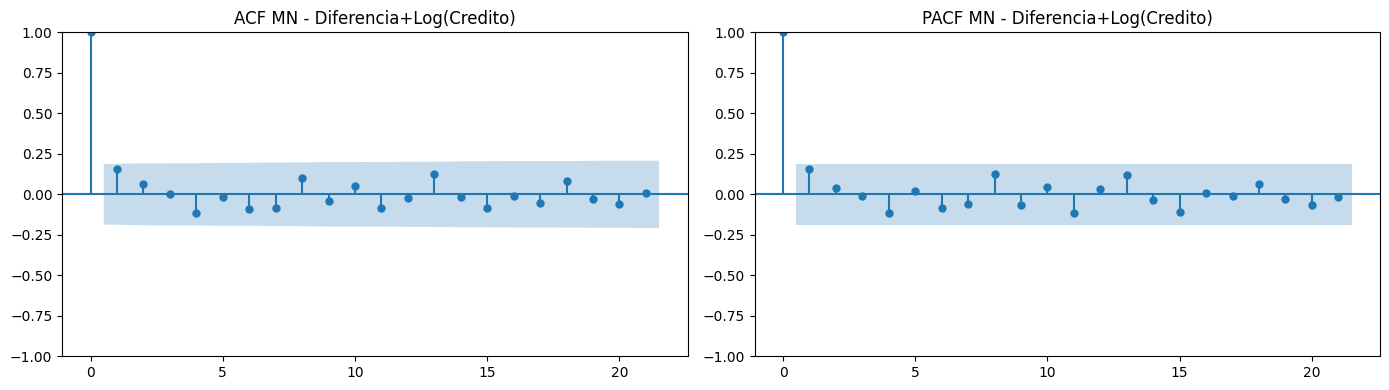

In [38]:
# Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(serie_log_diff_mn.dropna(), ax=axes[0],  title='ACF MN - Diferencia+Log(Credito)')
plot_pacf(serie_log_diff_mn.dropna(), ax=axes[1], title='PACF MN - Diferencia+Log(Credito)')
plt.tight_layout()
plt.show()

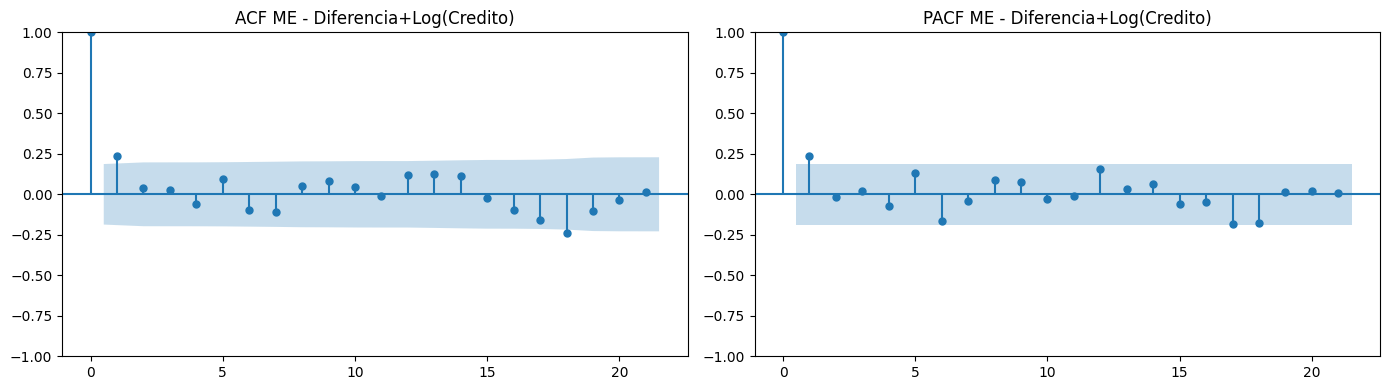

In [36]:
# Graficar ACF y PACF
fig, axes = plt.subplots(1, 2, figsize=(14, 4))
plot_acf(serie_log_diff_me.dropna(), ax=axes[0],  title='ACF ME - Diferencia+Log(Credito)')
plot_pacf(serie_log_diff_me.dropna(), ax=axes[1], title='PACF ME - Diferencia+Log(Credito)')
plt.tight_layout()
plt.show()

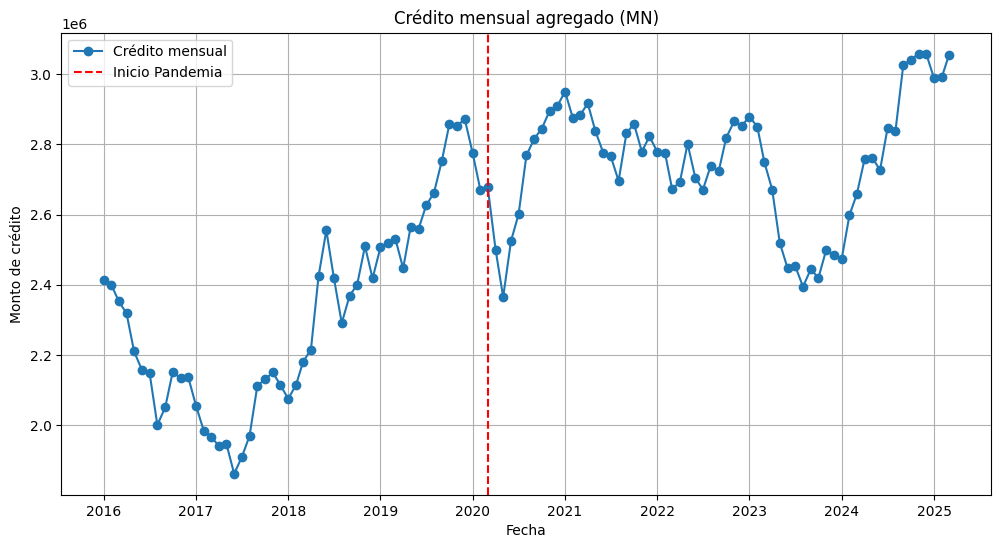

In [39]:
# Crear columna mes-año
df_mn['Mes_Año'] = df_mn.index.to_period('M')
serie_mensual = df_mn.groupby('Mes_Año')['Credito'].sum()

# Convertir a datetime para graficar
serie_mensual.index = serie_mensual.index.to_timestamp()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(serie_mensual, marker='o', label='Crédito mensual')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='Inicio Pandemia')
plt.title('Crédito mensual agregado (MN)')
plt.xlabel('Fecha')
plt.ylabel('Monto de crédito')
plt.legend()
plt.grid()
plt.show()

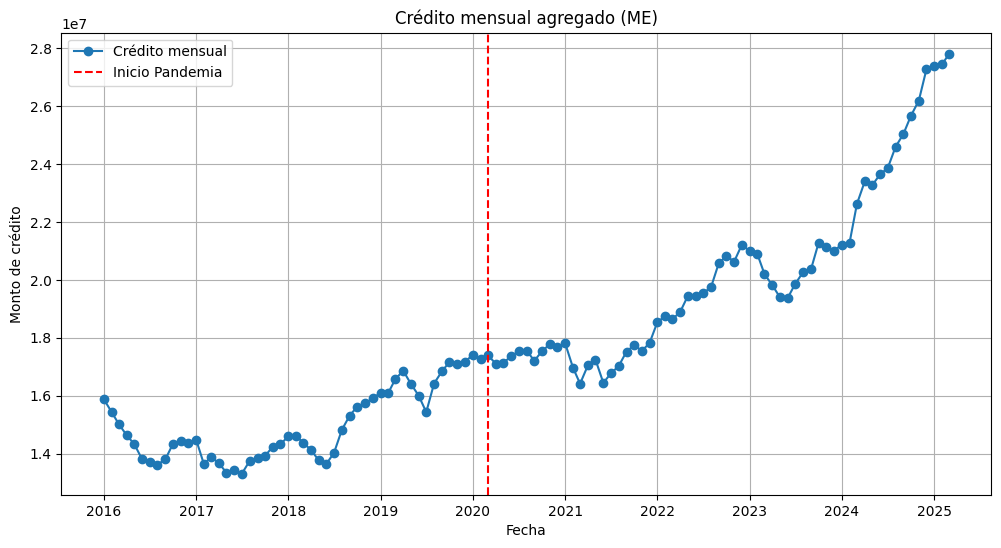

In [40]:
# Crear columna mes-año

df_me['Mes_Año'] = df_me.index.to_period('M')
serie_mensual = df_me.groupby('Mes_Año')['Credito'].sum()

# Convertir a datetime para graficar
serie_mensual.index = serie_mensual.index.to_timestamp()

# Graficar
plt.figure(figsize=(12,6))
plt.plot(serie_mensual, marker='o', label='Crédito mensual')
plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='Inicio Pandemia')
plt.title('Crédito mensual agregado (ME)')
plt.xlabel('Fecha')
plt.ylabel('Monto de crédito')
plt.legend()
plt.grid()
plt.show()


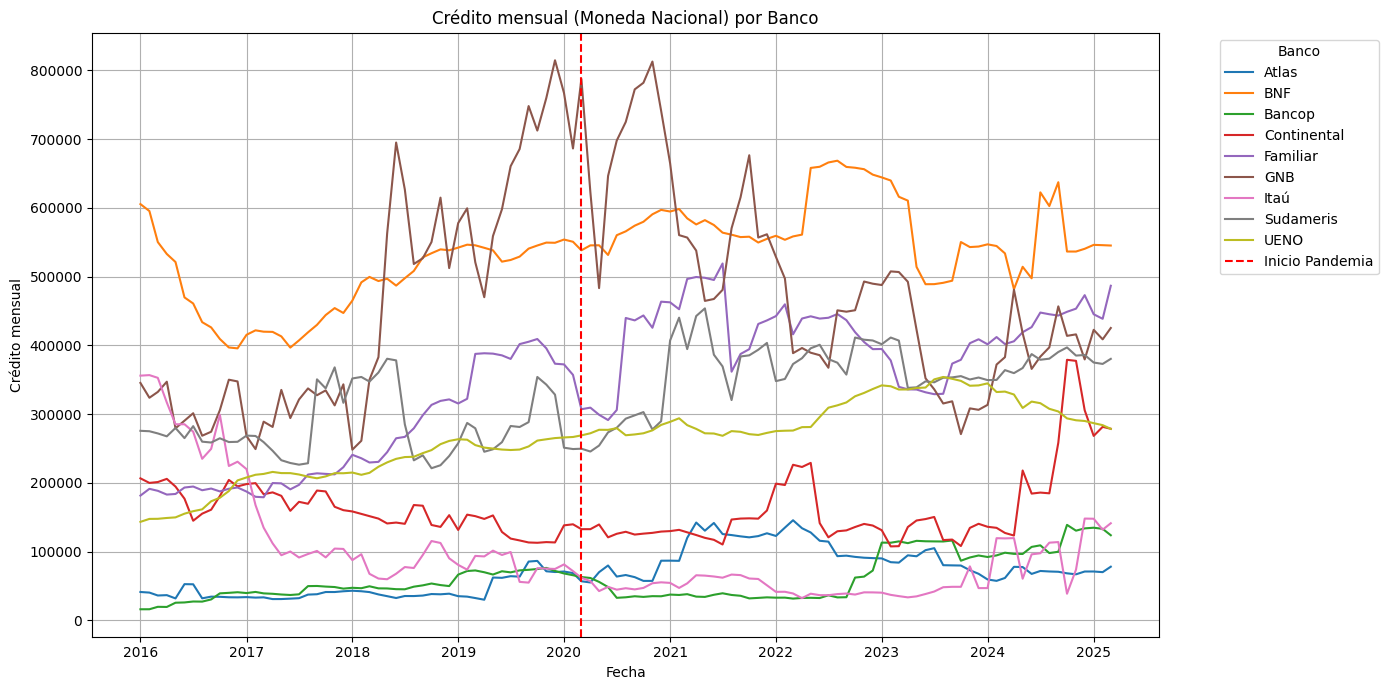

In [41]:
# Agrupar por mes y banco
bancos_exluidos = ['Citibank', 'Zeta', 'BNA', 'Do Brasil']
bancos_incluidos = ['GNB', 'Itaú', 'BNF', 'Atlas', 'UENO', 'Bancop', 'Familiar', 'Sudameris', 'Continental']
df_mn_filtro = df_mn[df_mn['Banco'].isin(bancos_incluidos)]
#df_mn_filtro = df_mn[~df_mn['Banco'].isin(bancos_exluidos)]
serie_mensual_banco = df_mn_filtro.groupby(['Mes_Año', 'Banco'])['Credito'].sum().unstack()

# Convertir el índice de periodo a datetime
serie_mensual_banco.index = serie_mensual_banco.index.to_timestamp()

# Graficar
plt.figure(figsize=(14,7))
for banco in serie_mensual_banco.columns:
    plt.plot(serie_mensual_banco.index, serie_mensual_banco[banco], label=banco)

plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='Inicio Pandemia')
plt.title('Crédito mensual (Moneda Nacional) por Banco')
plt.xlabel('Fecha')
plt.ylabel('Crédito mensual')
plt.legend(title='Banco', bbox_to_anchor=(1.05, 1), loc='upper left')  # leyenda afuera
plt.grid(True)
plt.tight_layout()
plt.show()

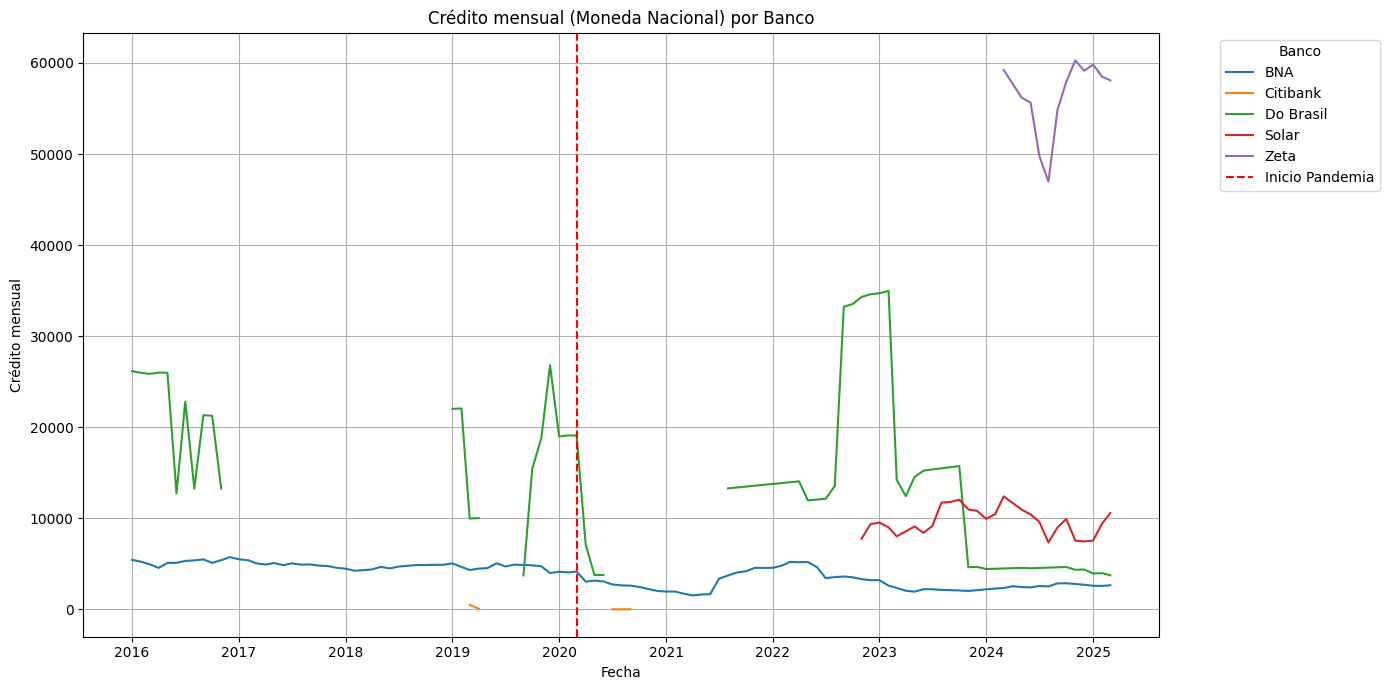

In [42]:
# Agrupar por mes y banco
bancos_exluidos = ['Citibank', 'Zeta', 'BNA', 'Do Brasil', 'Solar']
df_mn_filtro_ex = df_mn[df_mn['Banco'].isin(bancos_exluidos)]
serie_mensual_banco_ex = df_mn_filtro_ex.groupby(['Mes_Año', 'Banco'])['Credito'].sum().unstack()

# Convertir el índice de periodo a datetime
serie_mensual_banco_ex.index = serie_mensual_banco_ex.index.to_timestamp()

# Graficar
plt.figure(figsize=(14,7))
for banco in serie_mensual_banco_ex.columns:
    plt.plot(serie_mensual_banco_ex.index, serie_mensual_banco_ex[banco], label=banco)

plt.axvline(pd.to_datetime('2020-03-01'), color='red', linestyle='--', label='Inicio Pandemia')
plt.title('Crédito mensual (Moneda Nacional) por Banco')
plt.xlabel('Fecha')
plt.ylabel('Crédito mensual')
plt.legend(title='Banco', bbox_to_anchor=(1.05, 1), loc='upper left')  # leyenda afuera
plt.grid(True)
plt.tight_layout()
plt.show()

#### El plazo promedio de los créditos agrícolas en Paraguay puede variar según el tipo de crédito y la entidad financiera. Generalmente, se ofrecen opciones de hasta 7 años para capital de inversión, y hasta 4 años para el financiamiento de maquinaria y equipos usados. Para capital operativo, algunos créditos pueden tener plazos de hasta 2 años, mientras que otros pueden ser de 1 año.


          Banco  Participación promedio (%)
0           BNF                   21.013321
1           GNB                   18.243174
2      Familiar                   13.305685
3     Sudameris                   12.800604
4          UENO                   10.336347
5   Continental                    6.412561
6          Itaú                    4.046144
7          Basa                    3.207104
8     Interfisa                    2.967729
9         Atlas                    2.652743
10       Bancop                    2.359656
11         Zeta                    1.944705
12          Río                    1.823681
13    Do Brasil                    0.562699
14        Solar                    0.357646
15          BNA                    0.154341
16     Citibank                    0.010568


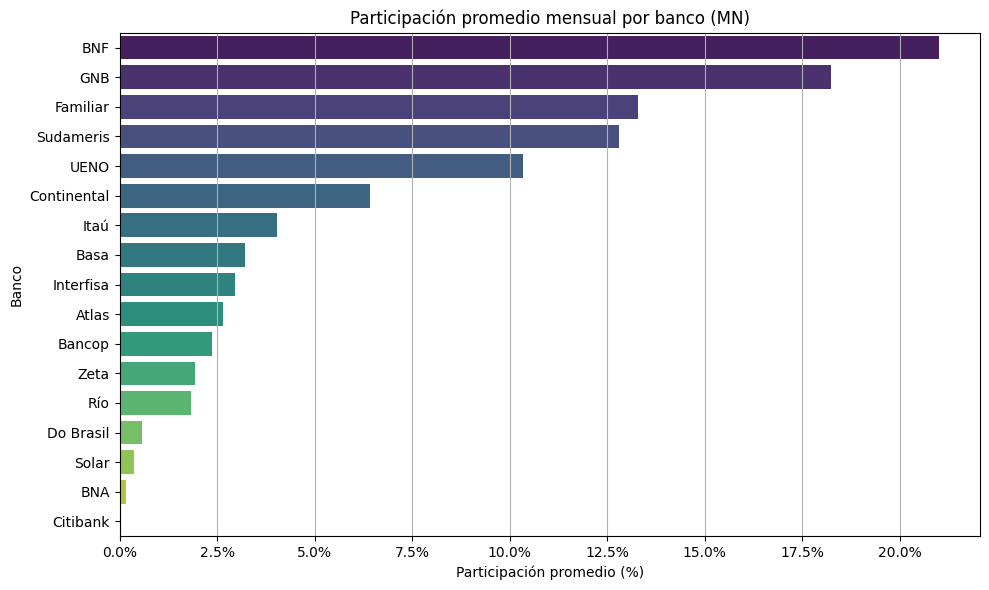

In [43]:
# Calcular el total mensual
total_mensual = df_mn.groupby(df_mn.index)["Credito"].sum()

# Calcular participación por banco
df_mn["Participacion"] = df_mn.apply(lambda row: row["Credito"] / total_mensual[row.name], axis=1)

# Promedio de participación por banco
participacion_promedio = df_mn.groupby("Banco")["Participacion"].mean().sort_values(ascending=False)


# Mostrar como tabla
tabla_participacion = participacion_promedio.reset_index()
tabla_participacion.columns = ['Banco', 'Participación promedio (%)']
tabla_participacion['Participación promedio (%)'] *= 100
print(tabla_participacion)

# Plot de barras
plt.figure(figsize=(10,6))
sns.barplot(data=tabla_participacion, x='Participación promedio (%)', y='Banco', palette='viridis', hue= 'Banco')
plt.title('Participación promedio mensual por banco (MN)')
plt.xlabel('Participación promedio (%)')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1f}%'))
plt.ylabel('Banco')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()


In [49]:
df_mn_filtrado = df_mn[df_mn.index >= "2020-01-01"].copy()
df_mn_filtrado["Año"] = df_mn_filtrado.index.year

# --- Agrupar: promedio de crédito por banco y año ---
importe_promedio_anual = df_mn_filtrado.groupby(["Año", "Banco"])["Credito"].mean().reset_index()

# --- Crear tabla tipo pivote ---
tabla_importes = importe_promedio_anual.pivot(index="Banco", columns="Año", values="Credito").fillna(0)
tabla_importes = tabla_importes.round(2).sort_index()

# Mostrar tabla
print("\nImporte promedio anual de crédito por banco (MN):")
tabla_importes.head(20)


Importe promedio anual de crédito por banco (MN):


Año,2020,2021,2022,2023,2024,2025
Banco,,,,,,
Atlas,66238.86,120730.20,113006.32,86111.02,68395.31,73014.36
BNA,3015.97,2899.82,4174.72,2242.27,2534.51,2594.24
BNF,561085.32,571310.32,625625.20,552067.50,549549.94,545697.51
Bancop,47314.88,35636.19,41370.01,108453.01,107863.09,130490.93
Basa,105705.53,116162.40,107759.54,109649.39,126355.32,129994.99
Citibank,254.43,0.00,0.00,0.00,0.00,0.00
Continental,130397.86,134268.12,167509.34,128500.66,217840.08,276114.31
Do Brasil,11962.03,13474.67,20079.62,16460.48,4499.64,3876.60
Familiar,370897.89,452867.16,431597.29,361545.68,431524.64,456835.85


In [ ]:
tabla_importes["Crecimiento"] = tabla_importes[2024] - tabla_importes[2020]
tabla_importes = tabla_importes.sort_values("Crecimiento", ascending=False)
# Mostrar tabla
print("\nImporte promedio anual de crédito por banco (MN):")
tabla_importes.head(20)


Importe promedio anual de crédito por banco (MN):


Año,2020,2021,2022,2023,2024,2025,Crecimiento
Banco,,,,,,,
Sudameris,272066.32,398390.05,382376.03,362986.61,374570.41,376104.96,102504.09
Continental,130397.86,134268.12,167509.34,128500.66,217840.08,276114.31,87442.22
Familiar,370897.89,452867.16,431597.29,361545.68,431524.64,456835.85,60626.75
Bancop,47314.88,35636.19,41370.01,108453.01,107863.09,130490.93,60548.21
Zeta,0.00,0.00,0.00,0.00,55772.78,58797.64,55772.78
Itaú,54617.37,59631.87,38481.84,44296.46,95510.97,140263.50,40893.60
UENO,273312.56,276636.93,301423.10,343107.57,313921.02,283058.44,40608.46
Río,26495.72,33117.06,30795.39,28269.61,48004.55,79322.78,21508.83
Basa,105705.53,116162.40,107759.54,109649.39,126355.32,129994.99,20649.79



Total de crédito otorgado por año (MN):
    Año       Credito
0  2016  2.647654e+07
1  2017  2.414298e+07
2  2018  2.797065e+07
3  2019  3.175033e+07
4  2020  3.234526e+07
5  2021  3.398938e+07
6  2022  3.309270e+07
7  2023  3.081192e+07
8  2024  3.384353e+07


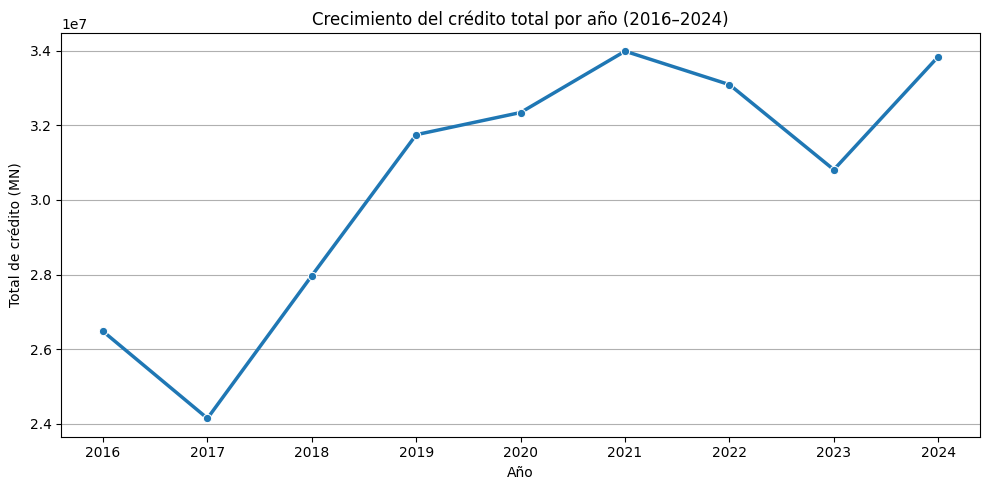


Crecimiento porcentual anual del total de crédito:
    Año      Credito  Crecimiento_%
0  2016  26476539.84            NaN
1  2017  24142984.74          -8.81
2  2018  27970647.47          15.85
3  2019  31750332.39          13.51
4  2020  32345257.26           1.87
5  2021  33989376.78           5.08
6  2022  33092700.92          -2.64
7  2023  30811923.52          -6.89
8  2024  33843528.56           9.84


In [53]:
df_mn["Año"] = df_mn.index.year

# Filtrar rango de años deseado
df_periodo = df_mn[(df_mn["Año"] >= 2016) & (df_mn["Año"] <= 2024)].copy()

# Agrupar por año y sumar el crédito total
total_anual_credito = df_periodo.groupby("Año")["Credito"].sum().reset_index()

# Mostrar tabla
print("\nTotal de crédito otorgado por año (MN):")
print(total_anual_credito)

plt.figure(figsize=(10, 5))
sns.lineplot(data=total_anual_credito, x="Año", y="Credito", marker="o", linewidth=2.5)
plt.title("Crecimiento del crédito total por año (2016–2024)")
plt.ylabel("Total de crédito (MN)")
plt.xlabel("Año")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

total_anual_credito["Crecimiento_%"] = total_anual_credito["Credito"].pct_change() * 100
print("\nCrecimiento porcentual anual del total de crédito:")
print(total_anual_credito.round(2))

In [47]:
total_mensual = df_mn.groupby(df_mn.index)["Credito"].sum()
df_mn["Participacion"] = df_mn.apply(
    lambda row: row["Credito"] / total_mensual[row.name],
    axis=1
)

# --- 3. Calcular participación promedio anual ---
df_mn["Año"] = df_mn.index.year
participacion_anual = df_mn.groupby(["Año", "Banco"])["Participacion"].mean().reset_index()
participacion_anual["Participacion"] *= 100  # Convertir a %

# --- 4. Crear tabla pivote ---
tabla_comparativa = participacion_anual.pivot(index="Banco", columns="Año", values="Participacion").fillna(0)
tabla_comparativa = tabla_comparativa.sort_index()

# Mostrar tabla
print("\nParticipación promedio anual por banco (%):")
print(tabla_comparativa.round(2))


Participación promedio anual por banco (%):
Año           2016   2017   2018   2019   2020   2021   2022   2023   2024  \
Banco                                                                        
Atlas         1.73   1.76   1.63   2.17   2.47   4.27   4.11   3.36   2.43   
BNA           0.24   0.25   0.20   0.18   0.11   0.10   0.15   0.09   0.09   
BNF          21.80  21.08  21.79  20.44  20.86  20.17  22.69  21.46  19.54   
Bancop        1.26   2.12   2.08   2.70   1.78   1.26   1.49   4.23   3.81   
Basa          0.74   1.55   2.43   3.17   3.92   4.10   3.90   4.28   4.48   
Citibank      0.00   0.00   0.00   0.02   0.01   0.00   0.00   0.00   0.00   
Continental   8.39   8.92   6.47   4.93   4.86   4.74   6.08   5.03   7.58   
Do Brasil     0.96   0.00   0.40   0.60   0.45   0.48   0.72   0.63   0.16   
Familiar      8.60   9.97  11.58  14.35  13.68  15.98  15.67  14.12  15.32   
GNB          14.22  15.31  20.62  24.15  26.27  19.74  15.95  14.88  14.13   
Interfisa     5.94 

In [ ]:
'''# Promedio mensual por banco

df_nuevo["Mes_nombre"] = df_nuevo["Fecha"].dt.strftime('%b')

plt.figure(figsize=(16, 10))
sns.set_style("whitegrid")

g = sns.catplot(
    data=df_nuevo,
    x="Mes_nombre",
    y="Credito",
    col="Banco",
    kind="point",
    estimator="mean",
    col_wrap=4,
    height=3.5,
    sharey=False
)

g.set_axis_labels("Mes", "Promedio Crédito")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Promedio mensual de créditos por banco (AGRICULTURA)", fontsize=16)

plt.show()'''


In [ ]:
'''# Graficar estacionalidad mensual (stacked line plot)
df_nuevo["Fecha"] = pd.to_datetime(df_nuevo["Fecha"])
df_nuevo["Mes"] = df_nuevo["Fecha"].dt.month
df_nuevo["Año"] = df_nuevo["Fecha"].dt.year
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")
sns.pointplot(df_nuevo, x='Mes', y='Credito', hue='Año', palette='viridis', linestyles='-')

plt.title('Estacionalidad Mensual de Creditos Agricolas')
plt.xlabel('Mes')
plt.ylabel('Creditos (Millones de Guaranies)')
plt.legend(title='Año', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()'''

In [ ]:
'''# Agrupar por banco y calcular varianza
varianzas = df_nuevo.groupby("Banco")["Credito"].var().sort_values(ascending=False)

# Mostrar top 10 bancos más volátiles
print("Top 10 bancos con mayor varianza en créditos:")
print(varianzas.head(10))

plt.figure(figsize=(12, 6))
varianzas.head(15).plot(kind='bar', color='coral')
plt.title("Top 15 Bancos con Mayor Varianza en Créditos - Sector AGRICULTURA")
plt.xlabel("Banco")
plt.ylabel("Varianza del Crédito")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()'''

In [ ]:
'''serie_sudameris = df_nuevo[df_nuevo["Banco"] == "Sudameris"].set_index("Fecha").sort_index()

plt.figure(figsize=(12, 5))
plt.plot(serie_sudameris.index, serie_sudameris["Credito"], marker='o', color='tomato')
plt.title("Evolución del Crédito - Banco Sudameris (Sector Agricultura)")
plt.xlabel("Fecha")
plt.ylabel("Crédito")
plt.grid(True)
plt.tight_layout()
plt.show()'''


In [ ]:
'''serie_sudameris = df_nuevo[df_nuevo["Banco"] == "Sudameris"].copy()
serie_sudameris = serie_sudameris.set_index("Fecha").sort_index()

# Calcular la diferencia absoluta mes a mes
serie_sudameris["Cambio_abs"] = serie_sudameris["Credito"].diff().abs()

# Encontrar el mes con el mayor cambio
max_cambio = serie_sudameris["Cambio_abs"].idxmax()
print(f"El mayor salto se dio en: {max_cambio.date()}")

# Mostrar los datos del mes del salto y los dos meses adyacentes
print("\nDetalle del salto:")
print(serie_sudameris.loc[max_cambio - pd.DateOffset(months=1):max_cambio + pd.DateOffset(months=1)][["Credito", "Cambio_abs"]])
'''

In [ ]:
'''serie_sudameris["Cambio_abs"] = serie_sudameris["Credito"].diff().abs()
serie_sudameris["Mes"] = serie_sudameris.index.month
cambios_por_mes = serie_sudameris.groupby("Mes")["Cambio_abs"].mean().reset_index()
# Convertir número de mes a nombre
cambios_por_mes["Mes"] = cambios_por_mes["Mes"].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(10, 5))
sns.barplot(data=cambios_por_mes, x="Mes", y="Cambio_abs", palette="viridis")

plt.title("Promedio de Cambios Absolutos Mensuales - Sudameris")
plt.ylabel("Cambio Absoluto Promedio")
plt.xlabel("Mes")
plt.tight_layout()
plt.show()'''

In [ ]:
'''# Seleccionar Sudameris y los siguientes 2 bancos más volátiles
top_bancos = ["Sudameris", "Continental", "GNB"]
df_top = df_nuevo[df_nuevo["Banco"].isin(top_bancos)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=df_top, x="Fecha", y="Credito", hue="Banco", marker='o')
plt.title("Comparación de Créditos Agrícolas - Bancos Más Volátiles")
plt.xlabel("Fecha")
plt.ylabel("Crédito")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()'''
